In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
import plotly.offline as pyo
import datetime
import matplotlib.dates as mdates
import sys
sys.path.insert(1, '../../auxiliary_scripts')
from output_postprocessing import parse_methane_series, parse_layer_file, parse_univariate_file, parse_T_fluxes
import matplotlib.dates as mdates
import itertools
import matplotlib.patches as mpatches

In [2]:
#specify names of files and corresponding variable names for dataframe proessing
layer_datafile_names={'layers': 'layers  1  1.dat'}

methane_datafile_names={'methane': 'methane_series  1  1.dat'}

t_fluxes_datafile_name='T_fluxes  1  1.dat'

univariate_datafile_names = {
                  'water_temp': 'water_temp  1  1f2.dat',
                  'co2_water': 'co2_water  1  1f2.dat',
                  'ch4_water': 'methane_water  1  1f2.dat',
                  'o2_water': 'oxygen_water  1  1f2.dat',
                  'doc_water': 'DOC  1  1f2.dat',
                  'pocl_water': 'POCL  1  1f2.dat', #live POC
                  'pocd_water': 'POCD  1  1f2.dat', #dead POC
                  'phosph_water': 'phosph_water  1  1f2.dat',
                  'prodox': 'prodox  1  1f2.dat',
                  'sod': 'sod  1  1f2.dat'} #dead POC
soil_temp_filename='soil_temp  1  1f2.dat'

In [3]:
#initialize arrays to store dataframes from individual runs
df_results = []
df_layers = []
df_methanes=[]
df_t_fluxes=[]
df_soil_temps=[]

#loop through simulation directories within met-exp folder
for dir in os.listdir():
    
    df_result = pd.DataFrame()
    
    if os.path.isdir(dir) and '.' not in dir:

        run_path = os.path.join(os.getcwd(), dir, 'time_series') #full path of time series directory

        df_layer = parse_layer_file(os.path.join(run_path, layer_datafile_names['layers'])) # parse layer file containing water, ice, snow thickness
        df_methane = parse_methane_series(os.path.join(run_path, methane_datafile_names['methane'])) # parse methane output file
        df_t_flux= parse_T_fluxes(os.path.join(run_path, t_fluxes_datafile_name))
        df_soil_temp=parse_univariate_file(os.path.join(run_path, soil_temp_filename), 'soil_temp')
        #loop through variables of interest that have outputs by water layer
        for var_key in univariate_datafile_names:

            # first file will initialize results datafrome for univariate data files
            if(len(df_result)==0):
                df_result = parse_univariate_file(os.path.join(run_path, univariate_datafile_names[var_key]), var_key)
            # subsequent files will be perged to dataframe based on index
            else: 
                df_result = pd.merge(df_result, parse_univariate_file(os.path.join(run_path, univariate_datafile_names[var_key]), var_key))
        
        # specify pond associated with run        
        if 'unburned' in dir:
            df_result['pond'] = 'unburned'
            df_layer['pond'] = 'unburned'
            df_methane['pond'] = 'unburned'
            df_t_flux['pond'] = 'unburned'
            df_soil_temp['pond'] = 'unburned'
        else:
            df_result['pond'] = 'burned'
            df_layer['pond'] = 'burned'
            df_methane['pond'] = 'burned'
            df_t_flux['pond'] = 'burned'
            df_soil_temp['pond'] = 'burned'
        
        # specify scenario associated with run
        run = ''.join(dir.split('-')[2:])
        
        if run == '':
            df_result['run'] = 'control'
            df_layer['run'] = 'control'
            df_methane['run'] = 'control'
            df_t_flux['run'] = 'control'
            df_soil_temp['run'] = 'control'
        else:
            df_result['run'] = run
            df_layer['run'] = run
            df_methane['run'] = run
            df_t_flux['run'] = run
            df_soil_temp['run'] = run

        # append data to scenario arrays
        df_results.append(df_result)
        df_layers.append(df_layer)
        df_methanes.append(df_methane)
        df_t_fluxes.append(df_t_flux)
        df_soil_temps.append(df_soil_temp)
        
# concatenate univariate data from individual runs
df_results = pd.concat(df_results)

# replace nodata value with nan
df_results = df_results.replace(-999, np.nan)
df_results = df_results.sort_values(by='run')

# concatenate layer data from individual runs
df_layers = pd.concat(df_layers)
df_layers = df_layers.replace(-999, np.nan)

# concatenate methane data from individual runs
df_methanes = pd.concat(df_methanes)

df_t_fluxes = pd.concat(df_t_fluxes)
df_t_fluxes = df_t_fluxes.sort_values(by='run')

df_soil_temps = pd.concat(df_soil_temps)
df_soil_temps = df_soil_temps.sort_values(by='run')

# replace nodata value with nan
df_methanes = df_methanes.replace(-999, np.nan)
df_methanes = df_methanes.sort_values(by='run')

# merge ice layer thickness data from layer file into main dataframe
df_results = pd.merge(df_results, df_layers[['Date', 'run', 'pond', 'ice layer thickness,   m', 'snow layer thickness,  m']], 
                      on = ['Date', 'run', 'pond'])

# merge ice layer thickness data from layer file into methane dataframe
df_methanes = pd.merge(df_methanes, df_layers[['Date', 'run', 'pond', 'ice layer thickness,   m', 'snow layer thickness,  m']], 
                      on = ['Date', 'run', 'pond'])

df_t_fluxes = pd.merge(df_t_fluxes, df_layers[['Date', 'run', 'pond', 'ice layer thickness,   m', 'snow layer thickness,  m', 'water layer thickness, m']], 
                      on = ['Date', 'run', 'pond'])

df_soil_temps = pd.merge(df_soil_temps, df_layers[['Date', 'run', 'pond', 'ice layer thickness,   m', 'snow layer thickness,  m', 'water layer thickness, m']], 
                      on = ['Date', 'run', 'pond'])

#filter results for last year of data
df_results = df_results.loc[(df_results['Date']>='2022-06-30') & (df_results['Date']<'2023-07-01')]
df_methanes = df_methanes.loc[(df_methanes['Date']>='2022-06-30') & (df_methanes['Date']<'2023-07-01')]
df_layers = df_layers.loc[(df_layers['Date']>='2022-07-01') & (df_layers['Date']<'2023-07-01')]
df_t_fluxes = df_t_fluxes.loc[(df_t_fluxes['Date']>='2022-07-01') & (df_t_fluxes['Date']<'2023-07-01')]
df_soil_temps = df_soil_temps.loc[(df_soil_temps['Date']>='2022-07-01') & (df_soil_temps['Date']<'2023-07-01')]

df_results['month_dt'] = pd.to_datetime(df_results[['year', 'month']].assign(DAY=1))
df_methanes['month_dt'] = pd.to_datetime(df_methanes[['year', 'month']].assign(DAY=1))
df_layers['month_dt'] = pd.to_datetime(df_layers[['year', 'month']].assign(DAY=1))
df_t_fluxes['month_dt'] = pd.to_datetime(df_t_fluxes[['year', 'month']].assign(DAY=1))
df_soil_temps['month_dt'] = pd.to_datetime(df_soil_temps[['year', 'month']].assign(DAY=1))

#average variables across depths for an alternative view of the data
df_results_depth_avg = df_results.groupby(by=['pond', 'run', 'Date']).mean().reset_index()

#filter for unfrozen depths
df_results=df_results.loc[((df_results['depth']==-1.4) & (df_results['pond']=='burned')) | ((df_results['depth']==-2.5) & (df_results['pond']=='unburned'))]
#df_results=df_results.loc[((df_results['depth']==-0.5) & (df_results['pond']=='burned')) | ((df_results['depth']==0.0) & (df_results['pond']=='unburned'))]

/tmp/ipykernel_4565/3451323164.py:120: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [4]:
# add a little more info to CH4 data
df_methanes['co2_turb_flux_mg/(m**2*day)'] = df_methanes['co2_turb_flux_mol/(m**2*s)'] *44.01*1e3*86400
df_methanes['co2_ebul_mg/(m**2*day)'] = df_methanes['co2_ebul_mol/(m**2*s)']*44.01*1e3*86400

df_methanes['ox_turb_flux_mg/(m**2*day)'] = df_methanes['ox_turb_flux_mol/(m**2*s)']*32.0*1e3*86400
df_methanes['ox_ebul_mg/(m**2*day)'] = df_methanes['ox_ebul_mol/(m**2*s)']*32.0*1e3*86400

#total ch4 and co2 flux
df_methanes['tot_ch4_flux'] = df_methanes['methane_turb_flux_mg/(m**2*day)'] + df_methanes['methane_ebul_mg/(m**2*day)'] + df_methanes['methane_plant_med_flux_mg/(m**2*day)']
df_methanes['tot_co2_flux'] = (df_methanes['co2_turb_flux_mg/(m**2*day)'] + df_methanes['co2_ebul_mg/(m**2*day)'])
df_methanes['tot_o2_flux'] = (df_methanes['ox_turb_flux_mg/(m**2*day)'] + df_methanes['ox_ebul_mg/(m**2*day)'])
df_methanes['methane_prod_young_mg/(m**2*day)'] = df_methanes['methane_prod_young_mol/(m**2*s)']*16*1e3*86400

df_methanes['ebullition_cumulative'] = df_methanes.sort_values(by=['pond', 'run', 'Date']).groupby(['pond', 'run'])['methane_ebul_mg/(m**2*day)'].cumsum()
df_methanes['diffusion_cumulative'] = df_methanes.sort_values(by=['pond', 'run', 'Date']).groupby(['pond', 'run'])['methane_turb_flux_mg/(m**2*day)'].cumsum()
df_methanes['oxidation_cumulative'] = df_methanes.sort_values(by=['pond', 'run', 'Date']).groupby(['pond', 'run'])['methane_oxid_mg/(m**2*day)'].cumsum()*-1
df_methanes['production_cumulative'] = df_methanes.sort_values(by=['pond', 'run', 'Date']).groupby(['pond', 'run'])['methane_prod_young_mol/(m**2*s)'].cumsum()
df_methanes['emission_cumulative'] = df_methanes.sort_values(by=['pond', 'run', 'Date']).groupby(['pond', 'run'])['tot_ch4_flux'].cumsum()

df_methanes['co2_ebullition_cumulative'] = df_methanes.sort_values(by=['pond', 'run', 'Date']).groupby(['pond', 'run'])['co2_ebul_mol/(m**2*s)'].cumsum()
df_methanes['co2_diffusion_cumulative'] = df_methanes.sort_values(by=['pond', 'run', 'Date']).groupby(['pond', 'run'])['co2_turb_flux_mol/(m**2*s)'].cumsum()
df_methanes['co2_emission_cumulative'] = df_methanes.sort_values(by=['pond', 'run', 'Date']).groupby(['pond', 'run'])['tot_co2_flux'].cumsum()

df_methanes['o2_ebullition_cumulative'] = df_methanes.sort_values(by=['pond', 'run', 'Date']).groupby(['pond', 'run'])['ox_ebul_mol/(m**2*s)'].cumsum()
df_methanes['o2_diffusion_cumulative'] = df_methanes.sort_values(by=['pond', 'run', 'Date']).groupby(['pond', 'run'])['ox_turb_flux_mol/(m**2*s)'].cumsum()
df_methanes['o2_emission_cumulative'] = df_methanes.sort_values(by=['pond', 'run', 'Date']).groupby(['pond', 'run'])['tot_o2_flux'].cumsum()

#cumulative percent difference
df_methanes = pd.merge(df_methanes, df_methanes.loc[df_methanes['run']=='5yr'][['pond', 'Date', 'emission_cumulative', 'co2_emission_cumulative', 'o2_emission_cumulative']], 
                       on=['pond', 'Date'], suffixes=['', '_control'])

df_methanes['emission_cumulative_pct'] = ((df_methanes['emission_cumulative'] - df_methanes['emission_cumulative_control']) / df_methanes['emission_cumulative_control']) * 100
df_methanes['co2_emission_cumulative_pct'] = ((df_methanes['co2_emission_cumulative'] - df_methanes['co2_emission_cumulative_control']) / df_methanes['co2_emission_cumulative_control']) * 100
df_methanes['o2_emission_cumulative'] = ((df_methanes['o2_emission_cumulative'] - df_methanes['o2_emission_cumulative_control']) / df_methanes['o2_emission_cumulative_control']) * 100



In [5]:
#reformat dataframes for box plots over ice-free and ice-on periods

#layered variables
sample_comp_melt = pd.melt(df_results.loc[(df_results['Date']>'2022-07-01') 
                           & (df_results['Date']<='2023-07-01')], 
                           id_vars=['Date', 'month', 'pond', 'run', 'ice layer thickness,   m'])

ice_free_box_data = sample_comp_melt.loc[sample_comp_melt['ice layer thickness,   m']==0]

ice_on_box_data = sample_comp_melt.loc[sample_comp_melt['ice layer thickness,   m']>0]

#methane varibles
methane_comp_melt=pd.melt(df_methanes.loc[(df_methanes['Date']>'2022-07-01') 
    & (df_methanes['Date']<='2023-07-01')], 
    id_vars=['Date', 'month', 'pond', 'run', 'ice layer thickness,   m'])

ice_free_ch4_data = methane_comp_melt.loc[methane_comp_melt['ice layer thickness,   m']==0]

ice_on_ch4_data = methane_comp_melt.loc[methane_comp_melt['ice layer thickness,   m']>0]

#t flux variables
t_fluxes_melt=pd.melt(df_t_fluxes.loc[(df_t_fluxes['Date']>'2022-07-01') 
    & (df_t_fluxes['Date']<='2023-07-01')], 
    id_vars=['Date', 'month', 'pond', 'run', 'ice layer thickness,   m', 'snow layer thickness,  m'])

ice_free_t_fluxes = t_fluxes_melt.loc[t_fluxes_melt['ice layer thickness,   m']==0]

ice_on_t_fluxes = t_fluxes_melt.loc[t_fluxes_melt['ice layer thickness,   m']>0]


In [6]:
snow_on_burned = df_layers.loc[(df_layers['run']=='5yr') & (df_layers['pond']=='burned') & (df_layers['snow layer thickness,  m']>0)].reset_index()
snow_on_unburned = df_layers.loc[(df_layers['run']=='5yr') & (df_layers['pond']=='unburned') & (df_layers['snow layer thickness,  m']>0)].reset_index()

In [7]:
print('burned first snow day: {}'.format(snow_on_burned.loc[0, 'Date']))
print('burned last snow day: {}'.format(snow_on_burned.loc[snow_on_burned.index[-1], 'Date']))
print('')
print('unburned first snow day: {}'.format(snow_on_unburned.loc[0, 'Date']))
print('unburned last snow day: {}'.format(snow_on_unburned.loc[snow_on_unburned.index[-1], 'Date']))

burned first snow day: 2022-11-03 00:00:00
burned last snow day: 2023-05-04 00:00:00

unburned first snow day: 2022-11-03 00:00:00
unburned last snow day: 2023-04-24 00:00:00


# Plot layer time series

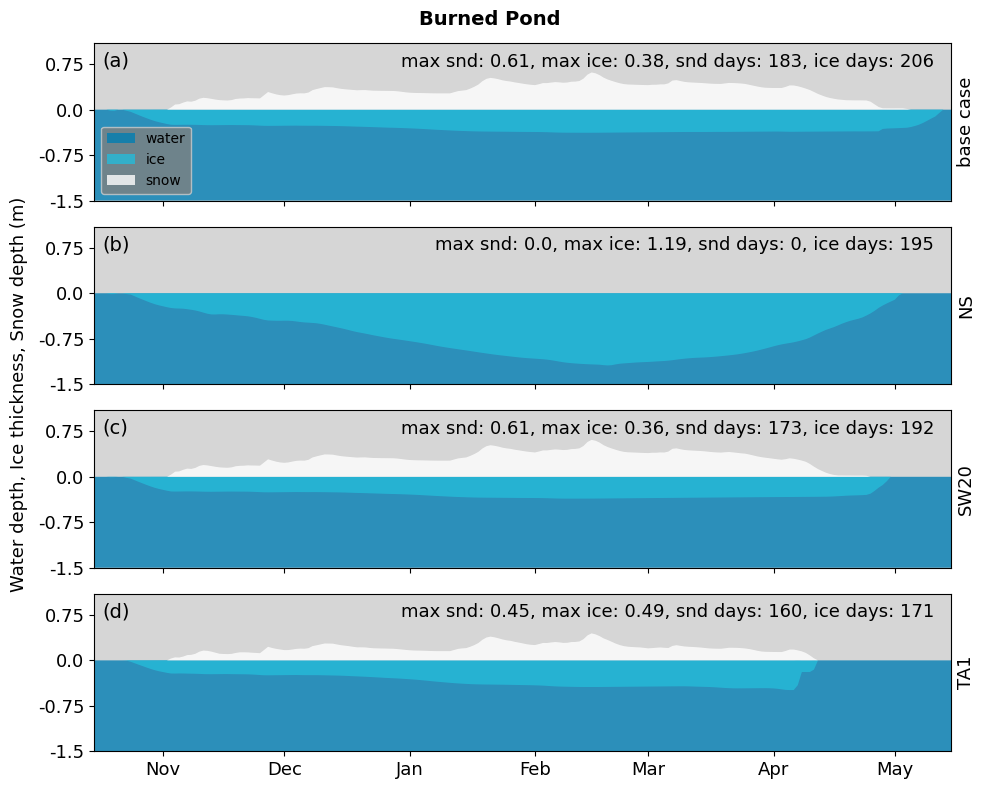

In [8]:
runs_names = df_results['run'].unique()
pond_name='burned'
#run_names_labels = ['base case', 'no snow', '+20% $\mathregular{SW_{in}}$', '+1% $\mathregular{T_{air}}$']
run_names_labels = ['base case', 'NS', 'SW20', 'TA1']
letter_labels=['(a)', '(b)', '(c)', '(d)']

fig, axes = plt.subplots(len(runs_names),1, figsize=(10,2*len(runs_names)), sharex=True, sharey=True)

for i, run in enumerate(runs_names):
    
    run_data = df_layers.loc[(df_layers['run']==runs_names[i]) & (df_layers['pond']==pond_name)]

    snd_max=round(run_data['snow layer thickness,  m'][-366:].max(),2)
    max_ice=round(run_data['ice layer thickness,   m'][-366:].max(),2)
    snd=run_data['snow layer thickness,  m'][-366:].copy()
    snd_days=round(snd[snd>0].count(),2)
    ice=run_data['ice layer thickness,   m'][-366:].copy()
    ice_days=round(ice[ice>0].count(),2)
    
    axes[i].fill_between(run_data['Date'], 0, run_data['water layer thickness, m'],  
                    facecolor ='#027eb3', alpha = 0.8, label='water')
    axes[i].fill_between(run_data['Date'], run_data['water layer thickness, m']-run_data['ice layer thickness,   m'], run_data['water layer thickness, m'],  
                    facecolor ='#25bbd9', alpha = 0.8, label='ice')
    axes[i].fill_between(run_data['Date'], run_data['water layer thickness, m'], run_data['snow layer thickness,  m'] + run_data['water layer thickness, m'],  
                    facecolor ='white', alpha = 0.8, label='snow')

    axes[i].set_facecolor('#d6d6d6')
    
    axes[i].set_ylabel(run_names_labels[i], fontsize=13)
    axes[i].yaxis.set_label_position("right")
    axes[i].set_facecolor('#d6d6d6')
    axes[i].tick_params(axis='both', which='major', labelsize=13)
    axes[i].text(0.01, 0.85,letter_labels[i], transform=axes[i].transAxes, fontsize=14)
    
    if pond_name=='burned':
        axes[i].text(0.98, 0.85, 'max snd: '+str(snd_max)+', max ice: '+str(max_ice)+
                      ', snd days: '+ str(snd_days)+', ice days: '+ str(ice_days), transform=axes[i].transAxes, fontsize=13, horizontalalignment='right')
        
        fig.suptitle('Burned Pond', fontsize=14, fontweight='bold')
        axes[i].set_yticks([0, 0.75, 1.5, 2.25])  # Set the ticks to be at these values
        axes[i].set_yticklabels([-1.5, -0.75, 0.0, 0.75], fontsize=13)  # Set the tick labels with a specific fontsize

        axes[0].legend(loc='lower left', facecolor = 'grey')
        axes[0].set_ylim(0, 2.6)
        
    else:
        axes[i].text(0.98, 0.1, 'max snd: '+str(snd_max)+', max ice: '+str(max_ice)+
                      ', snd days: '+ str(snd_days)+', ice days: '+ str(ice_days), transform=axes[i].transAxes, fontsize=13, horizontalalignment='right')
        
        fig.suptitle('Unburned Pond', fontsize=14, fontweight='bold')
        axes[i].set_yticks([0, 1, 2, 2.75, 3.5, 4.24])  # Set the ticks to be at these values
        axes[i].set_yticklabels([-2.75, -1.75, -0.75, 0.0, 0.75, ''], fontsize=13)  # Set the tick labels with a specific fontsize

        axes[0].legend(loc='lower left', facecolor = 'grey')

        axes[0].set_ylim(0, 3.75)
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)

plt.xticks(rotation=0)
plt.xlim(pd.to_datetime('2022-10-15'),pd.to_datetime('2023-05-15'))
fig.supylabel('Water depth, Ice thickness, Snow depth (m)', fontsize=13)
fig.tight_layout()

plt.savefig(f'met_exp_layers_{pond_name}.jpg', dpi=300)

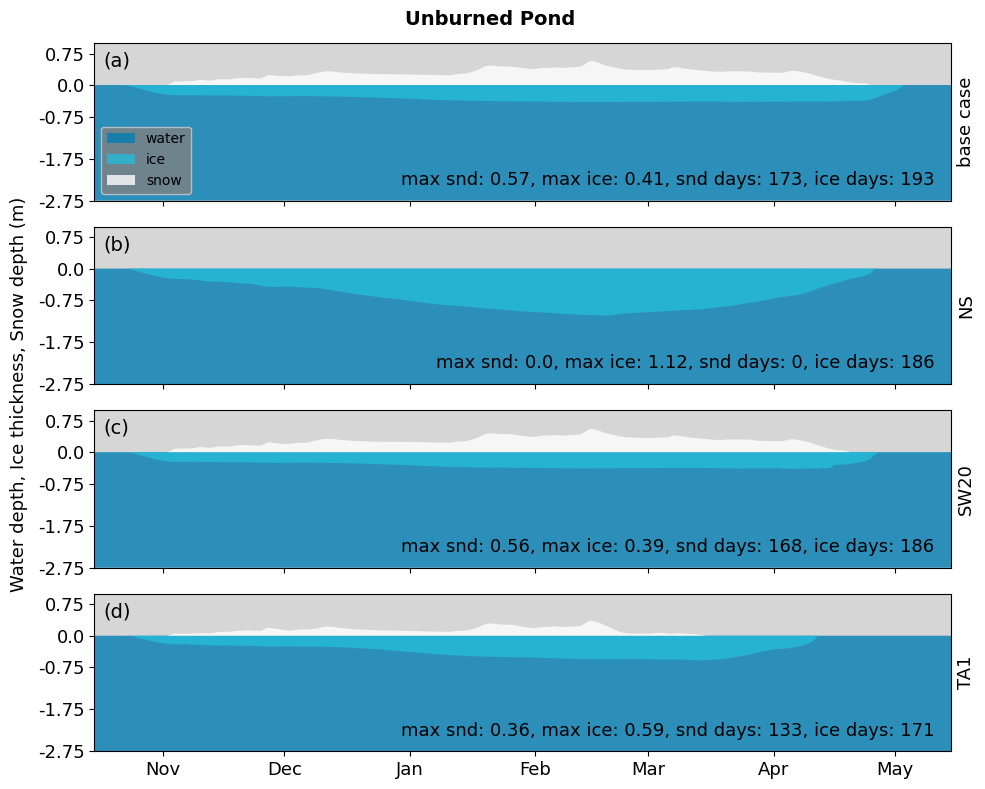

In [9]:
runs_names = df_results['run'].unique()
pond_name='unburned'

letter_labels=['(a)', '(b)', '(c)', '(d)']

fig, axes = plt.subplots(len(runs_names),1, figsize=(10,2*len(runs_names)), sharex=True, sharey=True)

for i, run in enumerate(runs_names):
    
    run_data = df_layers.loc[(df_layers['run']==runs_names[i]) & (df_layers['pond']==pond_name)]

    snd_max=round(run_data['snow layer thickness,  m'][-366:].max(),2)
    max_ice=round(run_data['ice layer thickness,   m'][-366:].max(),2)
    snd=run_data['snow layer thickness,  m'][-366:].copy()
    snd_days=round(snd[snd>0].count(),2)
    ice=run_data['ice layer thickness,   m'][-366:].copy()
    ice_days=round(ice[ice>0].count(),2)
    
    axes[i].fill_between(run_data['Date'], 0, run_data['water layer thickness, m'],  
                    facecolor ='#027eb3', alpha = 0.8, label='water')
    axes[i].fill_between(run_data['Date'], run_data['water layer thickness, m']-run_data['ice layer thickness,   m'], run_data['water layer thickness, m'],  
                    facecolor ='#25bbd9', alpha = 0.8, label='ice')
    axes[i].fill_between(run_data['Date'], run_data['water layer thickness, m'], run_data['snow layer thickness,  m'] + run_data['water layer thickness, m'],  
                    facecolor ='white', alpha = 0.8, label='snow')

    axes[i].set_facecolor('#d6d6d6')
    
    axes[i].set_ylabel(run_names_labels[i], fontsize=13)
    axes[i].yaxis.set_label_position("right")
    axes[i].set_facecolor('#d6d6d6')
    axes[i].tick_params(axis='both', which='major', labelsize=13)
    axes[i].text(0.01, 0.85,letter_labels[i], transform=axes[i].transAxes, fontsize=14)
    
    if pond_name=='burned':
        axes[i].text(0.98, 0.85, 'max snd: '+str(snd_max)+', max ice: '+str(max_ice)+
                      ', snd days: '+ str(snd_days)+', ice days: '+ str(ice_days), transform=axes[i].transAxes, fontsize=13, horizontalalignment='right')
        
        fig.suptitle('Burned Pond', fontsize=14, fontweight='bold')
        axes[i].set_yticks([0, 0.75, 1.5, 2.25])  # Set the ticks to be at these values
        axes[i].set_yticklabels([-1.5, -0.75, 0.0, 0.75], fontsize=13)  # Set the tick labels with a specific fontsize

        axes[0].legend(loc='lower left', facecolor = 'grey')
        axes[0].set_ylim(0, 2.6)
        
    else:
        axes[i].text(0.98, 0.1, 'max snd: '+str(snd_max)+', max ice: '+str(max_ice)+
                      ', snd days: '+ str(snd_days)+', ice days: '+ str(ice_days), transform=axes[i].transAxes, fontsize=13, horizontalalignment='right')
        
        fig.suptitle('Unburned Pond', fontsize=14, fontweight='bold')
        axes[i].set_yticks([0, 1, 2, 2.75, 3.5, 4.24])  # Set the ticks to be at these values
        axes[i].set_yticklabels([-2.75, -1.75, -0.75, 0.0, 0.75, ''], fontsize=13)  # Set the tick labels with a specific fontsize

        axes[0].legend(loc='lower left', facecolor = 'grey')

        axes[0].set_ylim(0, 3.75)

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)

plt.xticks(rotation=0)
plt.xlim(pd.to_datetime('2022-10-15'),pd.to_datetime('2023-05-15'))
fig.supylabel('Water depth, Ice thickness, Snow depth (m)', fontsize=13)
fig.tight_layout()

plt.savefig(f'met_exp_layers_{pond_name}.jpg', dpi=300)

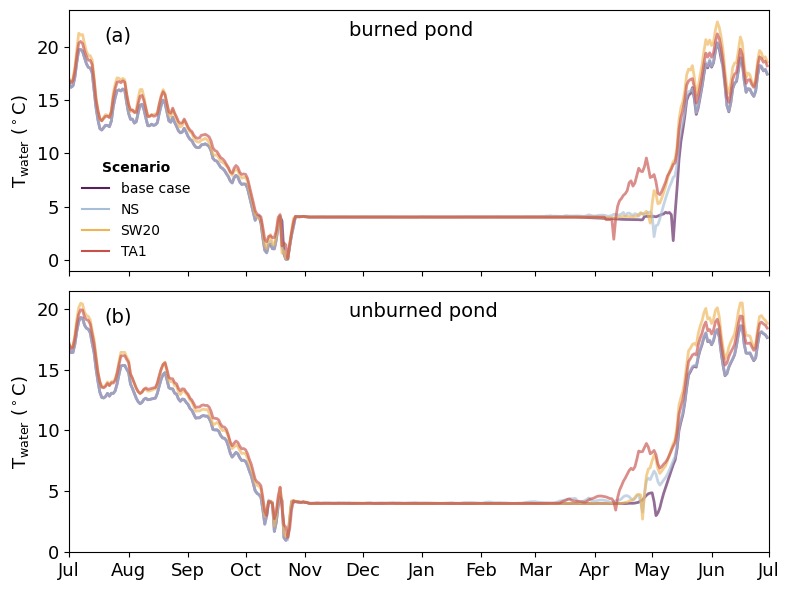

In [10]:
fig, axes = plt.subplots(2,1, figsize=(8,6), sharex=True)

pal = sns.color_palette(['#591f5c', '#A6BED8', '#EEB555', '#C7504B'])

sns.lineplot(data= df_results.loc[(df_results['pond']=='burned')], 
                 x='Date', y='water_temp', hue='run', alpha=0.65, linewidth=2, palette=pal, ax=axes[0])

axes[0].set_ylabel('$\mathregular{T_{water}}$ ($^\circ$C)', fontsize=13)
axes[0].set_xlabel('')
axes[0].tick_params(axis='both', which='major', labelsize=13)
axes[0].text(0.05, 0.88,'(a)', transform=axes[0].transAxes, fontsize=14)
axes[0].text(0.4, 0.9,'burned pond', transform=axes[0].transAxes, fontsize=14)

sns.lineplot(data= df_results.loc[(df_results['pond']=='unburned')], 
                 x='Date', y='water_temp', hue='run', alpha=0.65, linewidth=2, palette=pal, ax=axes[1], legend=False)

axes[1].set_ylabel('$\mathregular{T_{water}}$ ($^\circ$C)', fontsize=13)
axes[1].set_xlabel('')
axes[1].tick_params(axis='both', which='major', labelsize=13)
axes[1].text(0.05, 0.88,'(b)', transform=axes[1].transAxes, fontsize=14)
axes[1].text(0.4, 0.9,'unburned pond', transform=axes[1].transAxes, fontsize=14)

#ax.text(0.02, 0.95,'(a)', transform=ax.transAxes, fontsize=14)

plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-07-01'))

legend=axes[0].legend(title='Scenario', frameon=False, title_fontproperties={'weight':'bold'}, loc='lower left')

new_labels = ['base case', 'NS', 'SW20', 'TA1']

for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)

fig.tight_layout()

plt.savefig('met_exp_temp_comp.jpg', dpi=300)

In [11]:
df_results['run'].unique()

array(['5yr', 'nosnow5yr', 'swin20pct5yr', 'tplus1pct5yr'], dtype=object)

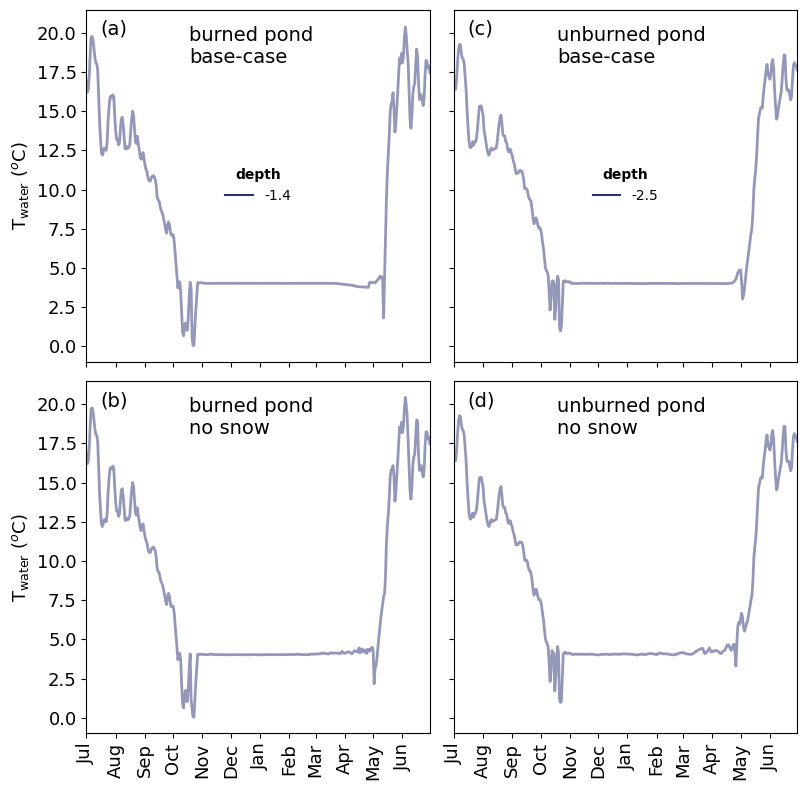

In [12]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True)
run = '5yr'
pond='burned'
pal = sns.color_palette(['#591f5c', '#A6BED8', '#EEB555', '#C7504B'])

sns.lineplot(data= df_results.loc[(df_results['pond']==pond) & 
                                  (df_results['run']==run)], 
                 x='Date', y='water_temp', hue='depth', alpha=0.5, linewidth=2, ax=axes[0,0], palette='crest_r')
axes[0,0].set_ylabel('$\mathregular{T_{water}}$ ($^o$C)', fontsize=13)
axes[0,0].set_xlabel('')
axes[0,0].tick_params(axis='both', which='major', labelsize=13)
axes[0,0].text(0.04, 0.93,'(a)', transform=axes[0,0].transAxes, fontsize=14)
axes[0,0].text(0.3, 0.85,'burned pond\nbase-case', transform=axes[0,0].transAxes, fontsize=14)
#axes[0,0].set_facecolor('#d6d6d6')

run = 'nosnow5yr'
pond='burned'
sns.lineplot(data= df_results.loc[(df_results['pond']==pond) & 
                                  (df_results['run']==run)], 
                 x='Date', y='water_temp', hue='depth', alpha=0.5, linewidth=2, ax=axes[1,0], legend=False, palette='crest_r')
axes[1,0].set_ylabel('$\mathregular{T_{water}}$ ($^o$C)', fontsize=13)
axes[1,0].set_xlabel('')
axes[1,0].tick_params(axis='both', which='major', labelsize=13)
axes[1,0].text(0.04, 0.93,'(b)', transform=axes[1,0].transAxes, fontsize=14)
axes[1,0].text(0.3, 0.85,'burned pond\nno snow', transform=axes[1,0].transAxes, fontsize=14)
#axes[1,0].set_facecolor('grey')

#ax.text(0.02, 0.95,'(a)', transform=ax.transAxes, fontsize=14)

plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-06-30'))

legend=axes[0,0].legend(title='depth', frameon=False, title_fontproperties={'weight':'bold'}, loc='center')

run = '5yr'
pond='unburned'
pal = sns.color_palette(['#591f5c', '#A6BED8', '#EEB555', '#C7504B'])

sns.lineplot(data= df_results.loc[(df_results['pond']==pond) & 
                                  (df_results['run']==run)], 
                 x='Date', y='water_temp', hue='depth', alpha=0.5, linewidth=2, ax=axes[0,1], palette='crest_r')
axes[0,1].set_ylabel('$\mathregular{T_{water}}$ ($^o$C)', fontsize=13)
axes[0,1].set_xlabel('')
axes[0,1].tick_params(axis='both', which='major', labelsize=13)
axes[0,1].text(0.04, 0.93,'(c)', transform=axes[0,1].transAxes, fontsize=14)
axes[0,1].text(0.3, 0.85,'unburned pond\nbase-case', transform=axes[0,1].transAxes, fontsize=14)
#axes[0,1].set_facecolor('#d6d6d6')

run = 'nosnow5yr'
pond='unburned'
sns.lineplot(data= df_results.loc[(df_results['pond']==pond) & 
                                  (df_results['run']==run)], 
                 x='Date', y='water_temp', hue='depth', alpha=0.5, linewidth=2, ax=axes[1,1], legend=False, palette='crest_r')
axes[1,1].set_ylabel('$\mathregular{T_{water}}$ ($^o$C)', fontsize=13)
axes[1,1].set_xlabel('')
axes[1,1].tick_params(axis='both', which='major', labelsize=13)
axes[1,1].text(0.04, 0.93,'(d)', transform=axes[1,1].transAxes, fontsize=14)
axes[1,1].text(0.3, 0.85,'unburned pond\nno snow', transform=axes[1,1].transAxes, fontsize=14)
#axes[1,1].set_facecolor('#d6d6d6')

#ax.text(0.02, 0.95,'(a)', transform=ax.transAxes, fontsize=14)

plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-06-30'))

legend=axes[0,1].legend(title='depth', frameon=False, title_fontproperties={'weight':'bold'}, loc='center')
#new_labels = ['base case', 'no snow', '+20% $\mathregular{SW_{in}}$', '+1% $\mathregular{T_{air}}$']
#for text, new_label in zip(legend.get_texts(), new_labels):
#    text.set_text(new_label)

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
fig.autofmt_xdate(rotation=90, ha='center')
fig.tight_layout()

plt.savefig('nosnow-temp-profile-comp.jpg', dpi=300)

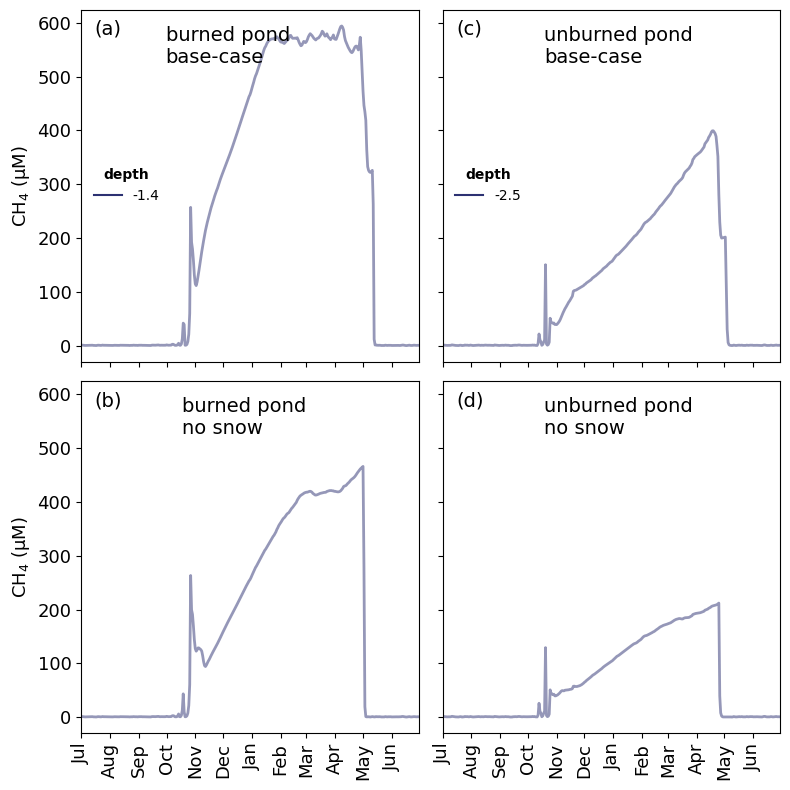

In [13]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True)
run = '5yr'
pond='burned'
pal = sns.color_palette(['#591f5c', '#A6BED8', '#EEB555', '#C7504B'])

sns.lineplot(data= df_results.loc[(df_results['pond']==pond) & 
                                  (df_results['run']==run)], 
                 x='Date', y='ch4_water', hue='depth', alpha=0.5, linewidth=2, ax=axes[0,0], palette='crest_r')
axes[0,0].set_ylabel(u'$\mathregular{CH_4}$ (\u03bcM)', fontsize=13)
axes[0,0].set_xlabel('')
axes[0,0].tick_params(axis='both', which='major', labelsize=13)
axes[0,0].text(0.04, 0.93,'(a)', transform=axes[0,0].transAxes, fontsize=14)
axes[0,0].text(0.25, 0.85,'burned pond\nbase-case', transform=axes[0,0].transAxes, fontsize=14)

run = 'nosnow5yr'
pond='burned'
sns.lineplot(data= df_results.loc[(df_results['pond']==pond) & 
                                  (df_results['run']==run)], 
                 x='Date', y='ch4_water', hue='depth', alpha=0.5, linewidth=2, ax=axes[1,0], legend=False, palette='crest_r')
axes[1,0].set_ylabel(u'$\mathregular{CH_4}$ (\u03bcM)', fontsize=13)
axes[1,0].set_xlabel('')
axes[1,0].tick_params(axis='both', which='major', labelsize=13)
axes[1,0].text(0.04, 0.93,'(b)', transform=axes[1,0].transAxes, fontsize=14)
axes[1,0].text(0.3, 0.85,'burned pond\nno snow', transform=axes[1,0].transAxes, fontsize=14)

#ax.text(0.02, 0.95,'(a)', transform=ax.transAxes, fontsize=14)

plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-06-30'))

legend=axes[0,0].legend(title='depth', frameon=False, title_fontproperties={'weight':'bold'}, loc='center left')

run = '5yr'
pond='unburned'
pal = sns.color_palette(['#591f5c', '#A6BED8', '#EEB555', '#C7504B'])

sns.lineplot(data= df_results.loc[(df_results['pond']==pond) & 
                                  (df_results['run']==run)], 
                 x='Date', y='ch4_water', hue='depth', alpha=0.5, linewidth=2, ax=axes[0,1], palette='crest_r')
axes[0,1].set_ylabel(u'$\mathregular{CH_4}$ (\u03bcM)', fontsize=13)
axes[0,1].set_xlabel('')
axes[0,1].tick_params(axis='both', which='major', labelsize=13)
axes[0,1].text(0.04, 0.93,'(c)', transform=axes[0,1].transAxes, fontsize=14)
axes[0,1].text(0.3, 0.85,'unburned pond\nbase-case', transform=axes[0,1].transAxes, fontsize=14)

run = 'nosnow5yr'
pond='unburned'
sns.lineplot(data= df_results.loc[(df_results['pond']==pond) & 
                                  (df_results['run']==run)], 
                 x='Date', y='ch4_water', hue='depth', alpha=0.5, linewidth=2, ax=axes[1,1], legend=False, palette='crest_r')
axes[1,1].set_ylabel(u'$\mathregular{CH_4}$ (\u03bcM)', fontsize=13)
axes[1,1].set_xlabel('')
axes[1,1].tick_params(axis='both', which='major', labelsize=13)
axes[1,1].text(0.04, 0.93,'(d)', transform=axes[1,1].transAxes, fontsize=14)
axes[1,1].text(0.3, 0.85,'unburned pond\nno snow', transform=axes[1,1].transAxes, fontsize=14)

#ax.text(0.02, 0.95,'(a)', transform=ax.transAxes, fontsize=14)

plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-06-30'))

legend=axes[0,1].legend(title='depth', frameon=False, title_fontproperties={'weight':'bold'}, loc='center left')
#new_labels = ['base case', 'no snow', '+20% $\mathregular{SW_{in}}$', '+1% $\mathregular{T_{air}}$']
#for text, new_label in zip(legend.get_texts(), new_labels):
#    text.set_text(new_label)

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
fig.autofmt_xdate(rotation=90, ha='center')
fig.tight_layout()

plt.savefig('nosnow-ch4-profile-comp.jpg', dpi=300)

In [14]:
df_soil_temps.loc[(df_soil_temps['pond']=='burned'), 'depth'].unique()

array([ -0.,  -1.,  -2.,  -3.,  -4.,  -5.,  -6.,  -7.,  -8.,  -9., -10.])

In [15]:
df_soil_temps.loc[(df_soil_temps['pond']=='unburned'), 'depth'].unique()

array([ -5.,  -6.,  -7.,  -8.,  -9., -10.,  -4.,  -3.,  -2.,  -1.,  -0.])

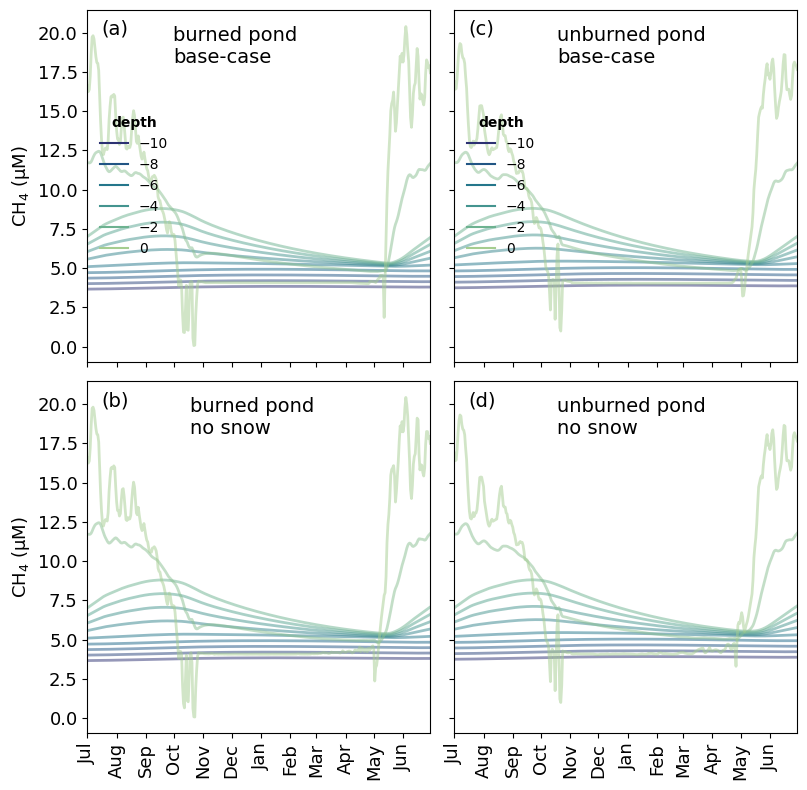

In [16]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True)
run = '5yr'
pond='burned'
pal = sns.color_palette(['#591f5c', '#A6BED8', '#EEB555', '#C7504B'])

sns.lineplot(data= df_soil_temps.loc[(df_soil_temps['pond']==pond) & 
                                  (df_soil_temps['run']==run)], 
                 x='Date', y='soil_temp', hue='depth', alpha=0.5, linewidth=2, ax=axes[0,0], palette='crest_r')
axes[0,0].set_ylabel(u'$\mathregular{CH_4}$ (\u03bcM)', fontsize=13)
axes[0,0].set_xlabel('')
axes[0,0].tick_params(axis='both', which='major', labelsize=13)
axes[0,0].text(0.04, 0.93,'(a)', transform=axes[0,0].transAxes, fontsize=14)
axes[0,0].text(0.25, 0.85,'burned pond\nbase-case', transform=axes[0,0].transAxes, fontsize=14)

run = 'nosnow5yr'
pond='burned'
sns.lineplot(data= df_soil_temps.loc[(df_soil_temps['pond']==pond) & 
                                  (df_soil_temps['run']==run)], 
                 x='Date', y='soil_temp', hue='depth', alpha=0.5, linewidth=2, ax=axes[1,0], legend=False, palette='crest_r')
axes[1,0].set_ylabel(u'$\mathregular{CH_4}$ (\u03bcM)', fontsize=13)
axes[1,0].set_xlabel('')
axes[1,0].tick_params(axis='both', which='major', labelsize=13)
axes[1,0].text(0.04, 0.93,'(b)', transform=axes[1,0].transAxes, fontsize=14)
axes[1,0].text(0.3, 0.85,'burned pond\nno snow', transform=axes[1,0].transAxes, fontsize=14)

#ax.text(0.02, 0.95,'(a)', transform=ax.transAxes, fontsize=14)

plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-06-30'))

legend=axes[0,0].legend(title='depth', frameon=False, title_fontproperties={'weight':'bold'}, loc='center left')

run = '5yr'
pond='unburned'
pal = sns.color_palette(['#591f5c', '#A6BED8', '#EEB555', '#C7504B'])

sns.lineplot(data= df_soil_temps.loc[(df_soil_temps['pond']==pond) & 
                                  (df_soil_temps['run']==run)], 
                 x='Date', y='soil_temp', hue='depth', alpha=0.5, linewidth=2, ax=axes[0,1], palette='crest_r')
axes[0,1].set_ylabel(u'$\mathregular{CH_4}$ (\u03bcM)', fontsize=13)
axes[0,1].set_xlabel('')
axes[0,1].tick_params(axis='both', which='major', labelsize=13)
axes[0,1].text(0.04, 0.93,'(c)', transform=axes[0,1].transAxes, fontsize=14)
axes[0,1].text(0.3, 0.85,'unburned pond\nbase-case', transform=axes[0,1].transAxes, fontsize=14)

run = 'nosnow5yr'
pond='unburned'
sns.lineplot(data= df_soil_temps.loc[(df_soil_temps['pond']==pond) & 
                                  (df_soil_temps['run']==run)], 
                 x='Date', y='soil_temp', hue='depth', alpha=0.5, linewidth=2, ax=axes[1,1], legend=False, palette='crest_r')
axes[1,1].set_ylabel(u'$\mathregular{CH_4}$ (\u03bcM)', fontsize=13)
axes[1,1].set_xlabel('')
axes[1,1].tick_params(axis='both', which='major', labelsize=13)
axes[1,1].text(0.04, 0.93,'(d)', transform=axes[1,1].transAxes, fontsize=14)
axes[1,1].text(0.3, 0.85,'unburned pond\nno snow', transform=axes[1,1].transAxes, fontsize=14)

#ax.text(0.02, 0.95,'(a)', transform=ax.transAxes, fontsize=14)

plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-06-30'))

legend=axes[0,1].legend(title='depth', frameon=False, title_fontproperties={'weight':'bold'}, loc='center left')
#new_labels = ['base case', 'no snow', '+20% $\mathregular{SW_{in}}$', '+1% $\mathregular{T_{air}}$']
#for text, new_label in zip(legend.get_texts(), new_labels):
#    text.set_text(new_label)

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
fig.autofmt_xdate(rotation=90, ha='center')
fig.tight_layout()

#plt.savefig('nosnow-ch4-profile-comp.jpg', dpi=300)

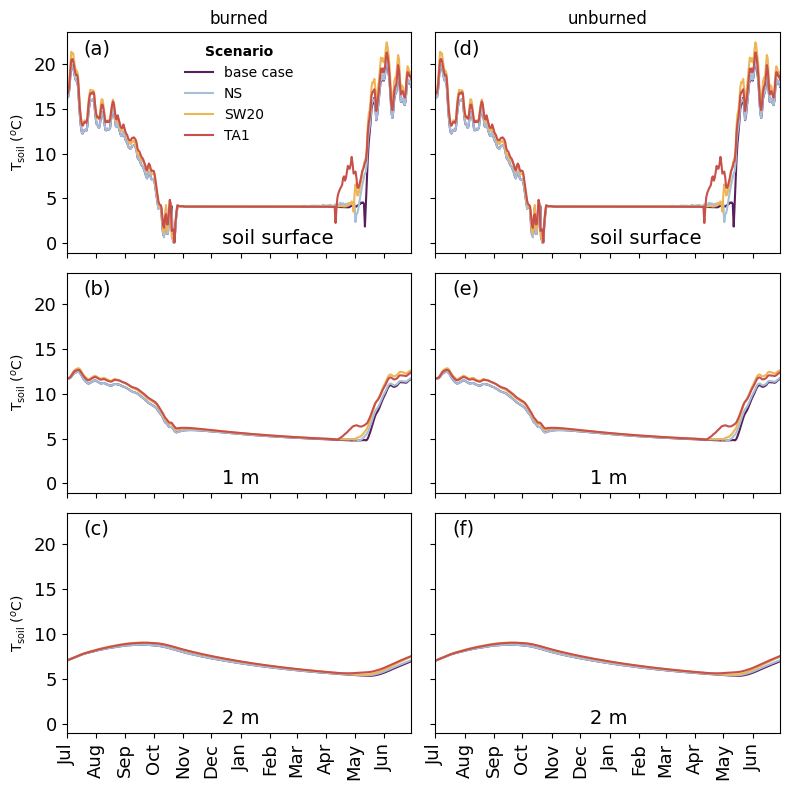

In [17]:
fig, axes = plt.subplots(3,2, figsize=(8,8), sharex=True, sharey=True)

pal = sns.color_palette(['#591f5c', '#A6BED8', '#EEB555', '#C7504B'])

sns.lineplot(data=df_soil_temps.loc[(df_soil_temps['pond']=='burned') & (df_soil_temps['depth']==0)], x='Date', y='soil_temp', hue='run', ax=axes[0,0], palette=pal)
axes[0,0].text(0.05, 0.9,'(a)', transform=axes[0,0].transAxes, fontsize=14)
axes[0,0].text(0.45, 0.04,'soil surface', transform=axes[0,0].transAxes, fontsize=14)
axes[0,0].tick_params(axis='both', which='major', labelsize=13)
axes[0,0].tick_params(axis='both', which='major', labelsize=13)
axes[0,0].set_title('burned')
axes[0,0].set_ylabel('$\mathregular{T_{soil}}$ ($^o$C)')

sns.lineplot(data=df_soil_temps.loc[(df_soil_temps['pond']=='burned') & (df_soil_temps['depth']==-1)], x='Date', 
             y='soil_temp', hue='run', ax=axes[1,0], palette=pal, legend=False)
axes[1,0].text(0.05, 0.9,'(b)', transform=axes[1,0].transAxes, fontsize=14)
axes[1,0].text(0.45, 0.04,'1 m', transform=axes[1,0].transAxes, fontsize=14)
axes[1,0].tick_params(axis='both', which='major', labelsize=13)
axes[1,0].tick_params(axis='both', which='major', labelsize=13)
axes[1,0].set_ylabel('$\mathregular{T_{soil}}$ ($^o$C)')

sns.lineplot(data=df_soil_temps.loc[(df_soil_temps['pond']=='burned') & (df_soil_temps['depth']==-2)], x='Date', 
             y='soil_temp', hue='run', ax=axes[2,0], palette=pal, legend=False)
axes[2,0].text(0.05, 0.9,'(c)', transform=axes[2,0].transAxes, fontsize=14)
axes[2,0].text(0.45, 0.04,'2 m', transform=axes[2,0].transAxes, fontsize=14)
axes[2,0].tick_params(axis='both', which='major', labelsize=13)
axes[2,0].set_xlabel('')
axes[2,0].tick_params(axis='both', which='major', labelsize=13)
axes[2,0].set_ylabel('$\mathregular{T_{soil}}$ ($^o$C)')

sns.lineplot(data=df_soil_temps.loc[(df_soil_temps['pond']=='burned') & (df_soil_temps['depth']==0)], x='Date', 
             y='soil_temp', hue='run', ax=axes[0,1], palette=pal, legend=False)
axes[0,1].text(0.45, 0.04,'soil surface', transform=axes[0,1].transAxes, fontsize=14)
axes[0,1].text(0.05, 0.9,'(d)', transform=axes[0,1].transAxes, fontsize=14)
axes[0,1].tick_params(axis='both', which='major', labelsize=13)
axes[0,1].set_xlabel('')
axes[0,1].set_title('unburned')
axes[0,1].set_ylabel('soil surface', fontsize=13)
axes[0,1].yaxis.set_label_position("right")

sns.lineplot(data=df_soil_temps.loc[(df_soil_temps['pond']=='burned') & (df_soil_temps['depth']==-1)], x='Date', 
             y='soil_temp', hue='run', ax=axes[1,1], palette=pal, legend=False)
axes[1,1].text(0.05, 0.9,'(e)', transform=axes[1,1].transAxes, fontsize=14)
axes[1,1].text(0.45, 0.04,'1 m', transform=axes[1,1].transAxes, fontsize=14)
axes[1,1].tick_params(axis='both', which='major', labelsize=13)
axes[1,1].tick_params(axis='both', which='major', labelsize=13)
axes[1,1].set_ylabel('1 m', fontsize=13)
axes[1,1].yaxis.set_label_position("right")

sns.lineplot(data=df_soil_temps.loc[(df_soil_temps['pond']=='burned') & (df_soil_temps['depth']==-2)], x='Date', 
             y='soil_temp', hue='run', ax=axes[2,1], palette=pal, legend=False)
axes[2,1].text(0.05, 0.9,'(f)', transform=axes[2,1].transAxes, fontsize=14)
axes[2,1].text(0.45, 0.04,'2 m', transform=axes[2,1].transAxes, fontsize=14)
axes[2,1].tick_params(axis='both', which='major', labelsize=13)
axes[2,1].set_xlabel('')
axes[2,1].tick_params(axis='both', which='major', labelsize=13)
axes[2,1].set_ylabel('2 m', fontsize=13)
axes[2,1].yaxis.set_label_position("right")

plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-06-30'))

legend=axes[0,0].legend(title='Scenario', frameon=False, title_fontproperties={'weight':'bold'}, loc='upper center')
new_labels = ['base case', 'NS', 'SW20', 'TA1']
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)


# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
fig.autofmt_xdate(rotation=90, ha='center')
fig.tight_layout()
plt.savefig('soil_temp_comp.jpg', dpi=300)

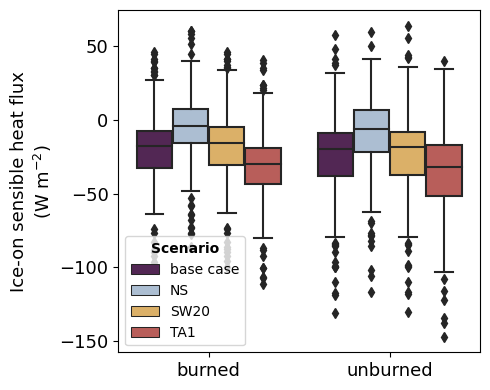

In [18]:
fig, ax=plt.subplots(figsize=(5,4))
sns.boxplot(data=ice_on_t_fluxes.loc[ice_on_t_fluxes['variable'] == 'sensible heat flux,    W/m**2'], 
            x='pond', y='value', hue='run', ax=ax, palette=pal)
#axes[0,0].legend(title='', loc='lower left')
legend=ax.legend(title='Scenario', frameon=True, title_fontproperties={'weight':'bold'}, loc='lower left')
new_labels = ['base case', 'NS', 'SW20', 'TA1']
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('Ice-on sensible heat flux\n(W $\mathregular{m^{-2}}$)', fontsize=13)
fig.tight_layout()
plt.savefig('wintertime_sens_hflux.jpg', dpi=300)

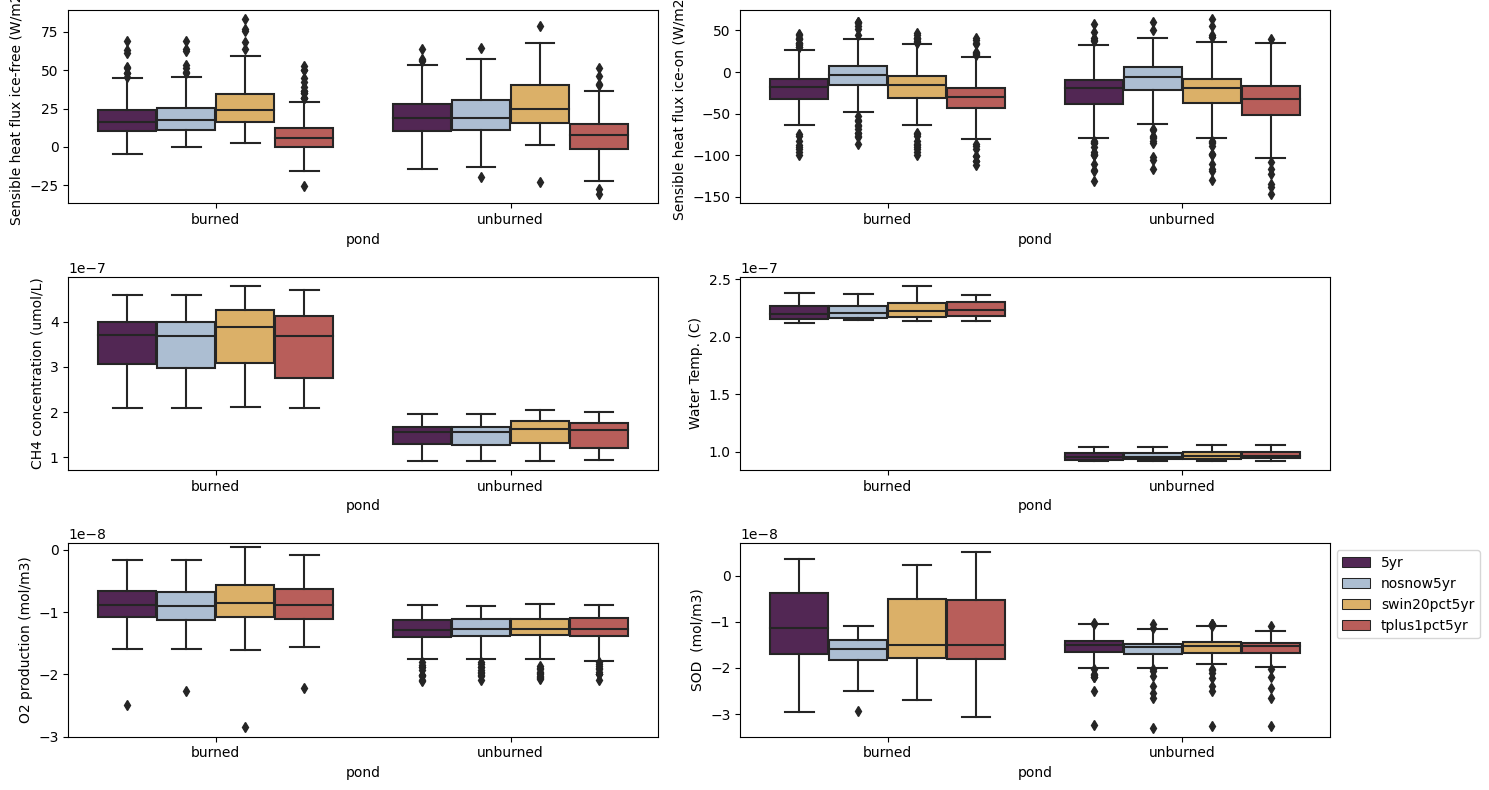

In [19]:
fig, axes=plt.subplots(3,2, figsize=(15,8))
sns.boxplot(data=ice_free_t_fluxes.loc[ice_free_t_fluxes['variable'] == 'sensible heat flux,    W/m**2'], 
            x='pond', y='value', hue='run', ax=axes[0,0], palette=pal)
#axes[0,0].legend(title='', loc='lower left')
axes[0,0].legend().remove()
axes[0,0].set_ylabel('Sensible heat flux ice-free (W/m2)')

sns.boxplot(data=ice_on_t_fluxes.loc[ice_on_t_fluxes['variable'] == 'sensible heat flux,    W/m**2'], 
            x='pond', y='value', hue='run', ax=axes[0,1], palette=pal)
axes[0,1].legend().remove()
axes[0,1].set_ylabel('Sensible heat flux ice-on (W/m2)')

sns.boxplot(data=ice_free_ch4_data.loc[ice_free_ch4_data['variable'] == 'methane_prod_young_mol/(m**2*s)'], 
            x='pond', y='value', hue='run', ax=axes[1,0], palette=pal)
axes[1,0].legend().remove()
axes[1,0].set_ylabel('CH4 concentration (umol/L)')


sns.boxplot(data=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_prod_young_mol/(m**2*s)'], 
            x='pond', y='value', hue='run', ax=axes[1,1], palette=pal)
axes[1,1].legend().remove()
axes[1,1].set_ylabel('Water Temp. (C)')

sns.boxplot(data=ice_free_ch4_data.loc[ice_free_ch4_data['variable'] == 'methane_diffuse_bot_mol/(m**2*s)'], 
            x='pond', y='value', hue='run', ax=axes[2,0], palette=pal)
axes[2,0].legend().remove()
axes[2,0].set_ylabel('O2 production (mol/m3)')
axes[2,0].set_ylim(-3e-8,.1e-8)
#axes[1,1].set_yscale('log')

sns.boxplot(data=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_diffuse_bot_mol/(m**2*s)'], 
            x='pond', y='value', hue='run', ax=axes[2,1], palette=pal)

axes[2,1].legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
axes[2,1].set_ylabel('SOD  (mol/m3)')

#axes[2,1].set_yscale('log')
#axes[1,2].set_ylim(0,1e-6)

fig.tight_layout()
#plt.savefig('met_exp_results_summer.jpg', dpi=300)

# Average water temperatures, concentrations over time, averaged across depths

In [20]:
df_results_merged_means = df_results_depth_avg.loc[(df_results_depth_avg['ice layer thickness,   m']==0) & 
                                                  (df_results_depth_avg['Date']>'2022-07-01')].groupby(by=['pond', 'run'])[['co2_water', 'ch4_water', 'o2_water']].mean()
df_results_merged_stds = df_results_depth_avg.loc[(df_results_depth_avg['ice layer thickness,   m']==0) & 
                                                  (df_results_depth_avg['Date']>'2022-07-01')].groupby(by=['pond', 'run'])[['co2_water', 'ch4_water', 'o2_water']].std()

In [21]:
df_results_merged_means

co2_water  ch4_water   o2_water
pond     run                                          
burned   5yr           43.363578   0.998764  10.545627
         nosnow5yr     42.976264   1.022726  10.674773
         swin20pct5yr  43.593787   0.991102  10.430982
         tplus1pct5yr  42.448038   0.961691  10.673397
unburned 5yr           95.747427   1.862800   8.719868
         nosnow5yr     94.713325   1.468728   8.806701
         swin20pct5yr  97.555707   2.976071   8.464316
         tplus1pct5yr  95.397174   0.999286   8.697950

In [22]:
df_results_merged_stds

co2_water  ch4_water  o2_water
pond     run                                         
burned   5yr            6.921082   0.991709  1.374569
         nosnow5yr      6.609081   1.471294  1.463937
         swin20pct5yr   7.863267   1.613280  1.566268
         tplus1pct5yr   7.188087   0.967808  1.514720
unburned 5yr           18.331306   5.709261  1.726809
         nosnow5yr     19.019380   4.551671  1.799749
         swin20pct5yr  21.208426  19.557788  1.905440
         tplus1pct5yr  20.121205   1.138741  1.884593

In [23]:
#twater_merged_means = df_results_depth_avg.loc[(df_results_depth_avg['Date']>'2022-07-01')].groupby(by=['pond', 'run'])[['water_temp']].mean()
#twater_merged_stds = df_results_depth_avg.loc[(df_results_depth_avg['Date']>'2022-07-01')].groupby(by=['pond', 'run'])[['water_temp']].std()

twater_merged_means = df_results.loc[(df_results['Date']>'2022-07-01')].groupby(by=['pond', 'run'])[['water_temp']].mean()
twater_merged_stds = df_results.loc[(df_results['Date']>'2022-07-01')].groupby(by=['pond', 'run'])[['water_temp']].std()

In [24]:
twater_merged_means

water_temp
pond     run                     
burned   5yr             7.719757
         nosnow5yr       7.828076
         swin20pct5yr    8.320898
         tplus1pct5yr    8.407468
unburned 5yr             7.847823
         nosnow5yr       7.962455
         swin20pct5yr    8.401332
         tplus1pct5yr    8.481428

In [25]:
twater_merged_stds

water_temp
pond     run                     
burned   5yr             5.379035
         nosnow5yr       5.365004
         swin20pct5yr    5.925610
         tplus1pct5yr    5.609595
unburned 5yr             5.166452
         nosnow5yr       5.110507
         swin20pct5yr    5.653768
         tplus1pct5yr    5.398859

In [26]:
cumulative_ch4_yrly = df_methanes.loc[(df_methanes['Date']>'2022-07-01')].groupby(by=['pond', 'run'])[['methane_ebul_mg/(m**2*day)', 'methane_turb_flux_mg/(m**2*day)',
                                                                                                       'methane_prod_young_mg/(m**2*day)', 'methane_oxid_mg/(m**2*day)',
                                                                                                       'co2_turb_flux_mg/(m**2*day)', 'co2_ebul_mg/(m**2*day)',
                                                                                                       'ox_turb_flux_mg/(m**2*day)', 'ox_ebul_mg/(m**2*day)',
                                                                                                       'tot_ch4_flux', 'tot_co2_flux', 'tot_o2_flux']].sum().reset_index()

cumulative_ch4_yrly = pd.merge(cumulative_ch4_yrly, cumulative_ch4_yrly.loc[cumulative_ch4_yrly['run']=='5yr'], on=['pond'], suffixes=['', '_control'])
cumulative_ch4_yrly['ebul_pct_change'] = ((cumulative_ch4_yrly['methane_ebul_mg/(m**2*day)'] - cumulative_ch4_yrly['methane_ebul_mg/(m**2*day)_control']) / cumulative_ch4_yrly['methane_ebul_mg/(m**2*day)_control']) * 100
cumulative_ch4_yrly['ebul_frac_pct_change'] = ((cumulative_ch4_yrly['methane_ebul_mg/(m**2*day)'] - cumulative_ch4_yrly['methane_ebul_mg/(m**2*day)_control']) / cumulative_ch4_yrly['tot_ch4_flux_control']) * 100
cumulative_ch4_yrly['diffuse_pct_change'] = ((cumulative_ch4_yrly['methane_turb_flux_mg/(m**2*day)'] - cumulative_ch4_yrly['methane_turb_flux_mg/(m**2*day)_control']) / cumulative_ch4_yrly['methane_turb_flux_mg/(m**2*day)_control']) * 100
cumulative_ch4_yrly['diffuse_frac_pct_change'] = ((cumulative_ch4_yrly['methane_turb_flux_mg/(m**2*day)'] - cumulative_ch4_yrly['methane_turb_flux_mg/(m**2*day)_control']) / cumulative_ch4_yrly['tot_ch4_flux_control']) * 100

cumulative_ch4_yrly['co2_ebul_frac_pct_change'] = ((cumulative_ch4_yrly['co2_ebul_mg/(m**2*day)'] - cumulative_ch4_yrly['co2_ebul_mg/(m**2*day)_control']) / cumulative_ch4_yrly['tot_co2_flux_control']) * 100
cumulative_ch4_yrly['co2_diffuse_frac_pct_change'] = ((cumulative_ch4_yrly['co2_turb_flux_mg/(m**2*day)'] - cumulative_ch4_yrly['co2_turb_flux_mg/(m**2*day)_control']) / cumulative_ch4_yrly['tot_co2_flux_control']) * 100

cumulative_ch4_yrly['o2_ebul_frac_pct_change'] = ((cumulative_ch4_yrly['ox_ebul_mg/(m**2*day)'] - cumulative_ch4_yrly['ox_ebul_mg/(m**2*day)_control']) / cumulative_ch4_yrly['tot_o2_flux_control']) * 100
cumulative_ch4_yrly['o2_diffuse_frac_pct_change'] = ((cumulative_ch4_yrly['ox_turb_flux_mg/(m**2*day)'] - cumulative_ch4_yrly['ox_turb_flux_mg/(m**2*day)_control']) / cumulative_ch4_yrly['tot_o2_flux_control']) * 100

cumulative_ch4_yrly['tot_ch4_flux_pct_change'] = ((cumulative_ch4_yrly['tot_ch4_flux'] - cumulative_ch4_yrly['tot_ch4_flux_control']) / cumulative_ch4_yrly['tot_ch4_flux_control']) * 100
cumulative_ch4_yrly['tot_co2_flux_pct_change'] = ((cumulative_ch4_yrly['tot_co2_flux'] - cumulative_ch4_yrly['tot_co2_flux_control']) / cumulative_ch4_yrly['tot_co2_flux_control']) * 100
cumulative_ch4_yrly['tot_o2_flux_pct_change'] = ((cumulative_ch4_yrly['tot_o2_flux'] - cumulative_ch4_yrly['tot_o2_flux_control']) / cumulative_ch4_yrly['tot_o2_flux_control']) * 100

In [27]:
cumulative_ch4_monthly = df_methanes.loc[(df_methanes['Date']>'2022-07-01')].groupby(by=['pond', 'run', 'month_dt'])[['methane_ebul_mg/(m**2*day)', 'methane_turb_flux_mg/(m**2*day)',
                                                                                                                   'methane_prod_young_mg/(m**2*day)', 'methane_oxid_mg/(m**2*day)',
                                                                                                                   'co2_turb_flux_mol/(m**2*s)', 'co2_ebul_mol/(m**2*s)',
                                                                                                                    'methane_diffuse_bot_mol/(m**2*s)',
                                                                                                                   'tot_ch4_flux', 'tot_co2_flux', 'tot_o2_flux']].sum().reset_index()
cumulative_ch4_monthly = pd.merge(cumulative_ch4_monthly, cumulative_ch4_monthly.loc[cumulative_ch4_monthly['run']=='5yr'], on=['pond', 'month_dt'], suffixes=['', '_control'])
cumulative_ch4_monthly['ebul_pct_change'] = ((cumulative_ch4_monthly['methane_ebul_mg/(m**2*day)'] - cumulative_ch4_monthly['methane_ebul_mg/(m**2*day)_control']) / cumulative_ch4_monthly['methane_ebul_mg/(m**2*day)_control']) * 100
cumulative_ch4_monthly['ch4_prod_pct_change'] = ((cumulative_ch4_monthly['methane_prod_young_mg/(m**2*day)'] - cumulative_ch4_monthly['methane_prod_young_mg/(m**2*day)_control']) / cumulative_ch4_monthly['methane_prod_young_mg/(m**2*day)_control']) * 100
cumulative_ch4_monthly['ch4_bot_diffuse_pct_change'] = ((cumulative_ch4_monthly['methane_diffuse_bot_mol/(m**2*s)'] - cumulative_ch4_monthly['methane_diffuse_bot_mol/(m**2*s)_control']) / cumulative_ch4_monthly['methane_diffuse_bot_mol/(m**2*s)_control']) * 100
cumulative_ch4_monthly['diffuse_pct_change'] = ((cumulative_ch4_monthly['methane_turb_flux_mg/(m**2*day)'] - cumulative_ch4_monthly['methane_turb_flux_mg/(m**2*day)_control']) / cumulative_ch4_monthly['methane_turb_flux_mg/(m**2*day)_control']) * 100
cumulative_ch4_monthly['tot_ch4_flux_pct_change'] = ((cumulative_ch4_monthly['tot_ch4_flux'] - cumulative_ch4_monthly['tot_ch4_flux_control']) / cumulative_ch4_monthly['tot_ch4_flux_control']) * 100
cumulative_ch4_monthly['tot_co2_flux_pct_change'] = ((cumulative_ch4_monthly['tot_co2_flux'] - cumulative_ch4_monthly['tot_co2_flux_control']) / cumulative_ch4_monthly['tot_co2_flux_control']) * 100
cumulative_ch4_monthly['tot_o2_flux_pct_change'] = ((cumulative_ch4_monthly['tot_o2_flux'] - cumulative_ch4_monthly['tot_o2_flux_control']) / cumulative_ch4_monthly['tot_o2_flux_control']) * 100
cumulative_ch4_monthly['tot_ch4_flux'] = cumulative_ch4_monthly['tot_ch4_flux'] / 1000 # g / month
cumulative_ch4_monthly['tot_co2_flux'] = cumulative_ch4_monthly['tot_co2_flux'] / 1000 # g / month
cumulative_ch4_monthly['tot_o2_flux'] = cumulative_ch4_monthly['tot_o2_flux'] / 1000 # g / month
cumulative_ch4_monthly['methane_ebul_mg/(m**2*day)'] = cumulative_ch4_monthly['methane_ebul_mg/(m**2*day)'] / 1000
cumulative_ch4_monthly['methane_turb_flux_mg/(m**2*day)'] = cumulative_ch4_monthly['methane_turb_flux_mg/(m**2*day)'] / 1000
cumulative_ch4_monthly['methane_oxid_mg/(m**2*day)'] = cumulative_ch4_monthly['methane_oxid_mg/(m**2*day)'] / 1000
cumulative_ch4_monthly['methane_prod_young_mg/(m**2*day)'] = cumulative_ch4_monthly['methane_prod_young_mg/(m**2*day)'] / 1000

In [28]:
df_methanes.columns

Index(['Date', 'year', 'month', 'day', 'hour', 'talik depth, m',
       'lake surface methane concentration, mol/m**3',
       'lake bottom methane concentration, mol/m**3',
       'methane_prod_young_mol/(m**2*s)', 'methane_prod_old_mol/(m**2*s)',
       'methane_diffuse_bot_mol/(m**2*s)', 'methane_ebul_mol/(m**2*s)',
       'methane_ebul_mg/(m**2*day)', 'methane_turb_flux_mol/(m**2*s)',
       'methane_turb_flux_mg/(m**2*day)', 'methane_oxid_mg/(m**2*day)',
       'methane_plant_med_flux_mg/(m**2*day)', 'co2_turb_flux_mol/(m**2*s)',
       'co2_ebul_mol/(m**2*s)', 'ox_turb_flux_mol/(m**2*s)',
       'ox_ebul_mol/(m**2*s)', 'methane_ebul_sc1', 'methane_ebul_sc2',
       'methane_ebul_sc3', 'methane_ebul_sc4', 'methane_ebul_sc5', 'run_name',
       'pond', 'run', 'ice layer thickness,   m', 'snow layer thickness,  m',
       'month_dt', 'co2_turb_flux_mg/(m**2*day)', 'co2_ebul_mg/(m**2*day)',
       'ox_turb_flux_mg/(m**2*day)', 'ox_ebul_mg/(m**2*day)', 'tot_ch4_flux',
       'tot_co2_

In [29]:
sns.color_palette().as_hex()

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [30]:
print(sns.color_palette().as_hex())

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


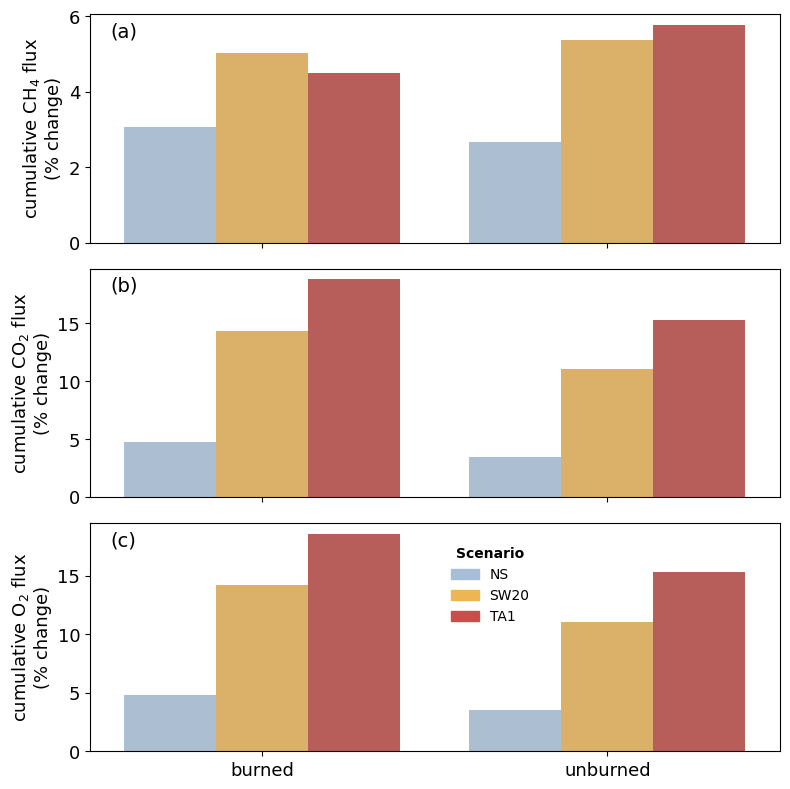

In [31]:
pal = sns.color_palette(['#A6BED8', '#EEB555', '#C7504B'])
pal_ebul = sns.color_palette(['#1f77b4', '#ff7f0e', '#d62728'])


fig, axes = plt.subplots(3, 1, figsize=(8,8), sharex=True)
sns.barplot(data=cumulative_ch4_yrly.loc[cumulative_ch4_yrly['run']!='5yr'], x='pond', 
            y=cumulative_ch4_yrly.loc[cumulative_ch4_yrly['run']!='5yr', 'ebul_frac_pct_change']+cumulative_ch4_yrly.loc[cumulative_ch4_yrly['run']!='5yr', 'diffuse_frac_pct_change'], 
            hue='run', ax=axes[0], palette=pal)
#sns.barplot(data=cumulative_ch4_yrly.loc[cumulative_ch4_yrly['run']!='5yr'], x='pond', y='ebul_frac_pct_change', hue='run', palette=pal_ebul, ax=axes[0])

#num_locations = 6
#hatches = itertools.cycle(['.', 'o'])
#for i, bar in enumerate(axes[0].patches):
#    if i % num_locations == 0:
#        hatch = next(hatches)
#    bar.set_hatch(hatch)
    
axes[0].set_ylabel(u'cumulative $\mathregular{CH_4}$ flux\n(% change)', fontsize=13)
axes[0].set_xlabel('')
axes[0].tick_params(axis='both', which='major', labelsize=13)

axes[0].text(0.03, 0.9,'(a)', transform=axes[0].transAxes, fontsize=14)

legend=axes[0].legend()
legend.remove()

sns.barplot(data=cumulative_ch4_yrly.loc[cumulative_ch4_yrly['run']!='5yr'], x='pond', 
            y=cumulative_ch4_yrly.loc[cumulative_ch4_yrly['run']!='5yr', 'co2_ebul_frac_pct_change']+cumulative_ch4_yrly.loc[cumulative_ch4_yrly['run']!='5yr', 'co2_diffuse_frac_pct_change'], 
            hue='run', ax=axes[1], palette=pal)
#sns.barplot(data=cumulative_ch4_yrly.loc[cumulative_ch4_yrly['run']!='5yr'], x='pond', y='co2_ebul_frac_pct_change', hue='run', palette=pal_ebul, ax=axes[1])

axes[1].set_ylabel(u'cumulative $\mathregular{CO_2}$ flux\n(% change)', fontsize=13)
axes[1].set_xlabel('')
axes[1].tick_params(axis='both', which='major', labelsize=13)

axes[1].text(0.03, 0.9,'(b)', transform=axes[1].transAxes, fontsize=14)

legend=axes[1].legend()
legend.remove()


sns.barplot(data=cumulative_ch4_yrly.loc[cumulative_ch4_yrly['run']!='5yr'], x='pond', 
            y=cumulative_ch4_yrly.loc[cumulative_ch4_yrly['run']!='5yr', 'o2_ebul_frac_pct_change']+cumulative_ch4_yrly.loc[cumulative_ch4_yrly['run']!='5yr', 'o2_diffuse_frac_pct_change'], 
            hue='run', ax=axes[2], palette=pal)
#sns.barplot(data=cumulative_ch4_yrly.loc[cumulative_ch4_yrly['run']!='5yr'], x='pond', y='o2_ebul_frac_pct_change', hue='run', palette=pal_ebul, ax=axes[2])

axes[2].set_ylabel(u'cumulative $\mathregular{O_2}$ flux\n(% change)', fontsize=13)
axes[2].set_xlabel('Pond', fontsize=13)
axes[2].tick_params(axis='both', which='major', labelsize=13)
axes[2].text(0.03, 0.9,'(c)', transform=axes[2].transAxes, fontsize=14)

sn_patch = mpatches.Patch(color='#A6BED8', label='NS')
sw_patch = mpatches.Patch(color='#EEB555', label='SW20')
t_patch = mpatches.Patch(color='#C7504B', label='TA1')
d_patch = mpatches.Patch(color='#dedede', label='diffusion')
e_patch = mpatches.Patch(color='#8a8a8a', label='ebullition')

axes[2].legend(title='Scenario', frameon=False, title_fontproperties={'weight':'bold'}, loc='upper center',
                handles=[sn_patch, sw_patch, t_patch],
                bbox_to_anchor=(0.58, 0.95))
#axes[2].legend(title='flux', frameon=False, title_fontproperties={'weight':'bold'}, loc='upper left',
#                handles=[d_patch, e_patch])

new_labels = ['NS', 'SW20', 'TA1']
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
plt.xlabel('')
fig.tight_layout()

plt.savefig('gas_flux_comp.jpg', dpi=300)

In [70]:
#g/m2/yr
cumulative_ch4_yrly[['pond', 'run', 'tot_ch4_flux', 'tot_co2_flux', 'tot_o2_flux']].set_index(['pond', 'run'])*1e-3

tot_ch4_flux  tot_co2_flux  tot_o2_flux
pond     run                                                  
burned   5yr             130.136810    467.294692   350.860109
         nosnow5yr       134.126081    489.377546   367.789113
         swin20pct5yr    136.682217    534.483881   400.887602
         tplus1pct5yr    135.986349    555.151873   416.136518
unburned 5yr              56.300968   1330.317602  1000.694179
         nosnow5yr        57.799168   1376.335763  1035.657004
         swin20pct5yr     59.322500   1477.266276  1111.131007
         tplus1pct5yr     59.551929   1533.254212  1153.818557

In [33]:
cumulative_ch4_yrly['tot_ch4_flux']/1000

0    130.136810
1    134.126081
2    136.682217
3    135.986349
4     56.300968
5     57.799168
6     59.322500
7     59.551929
Name: tot_ch4_flux, dtype: float64

In [34]:
df_methanes.columns

Index(['Date', 'year', 'month', 'day', 'hour', 'talik depth, m',
       'lake surface methane concentration, mol/m**3',
       'lake bottom methane concentration, mol/m**3',
       'methane_prod_young_mol/(m**2*s)', 'methane_prod_old_mol/(m**2*s)',
       'methane_diffuse_bot_mol/(m**2*s)', 'methane_ebul_mol/(m**2*s)',
       'methane_ebul_mg/(m**2*day)', 'methane_turb_flux_mol/(m**2*s)',
       'methane_turb_flux_mg/(m**2*day)', 'methane_oxid_mg/(m**2*day)',
       'methane_plant_med_flux_mg/(m**2*day)', 'co2_turb_flux_mol/(m**2*s)',
       'co2_ebul_mol/(m**2*s)', 'ox_turb_flux_mol/(m**2*s)',
       'ox_ebul_mol/(m**2*s)', 'methane_ebul_sc1', 'methane_ebul_sc2',
       'methane_ebul_sc3', 'methane_ebul_sc4', 'methane_ebul_sc5', 'run_name',
       'pond', 'run', 'ice layer thickness,   m', 'snow layer thickness,  m',
       'month_dt', 'co2_turb_flux_mg/(m**2*day)', 'co2_ebul_mg/(m**2*day)',
       'ox_turb_flux_mg/(m**2*day)', 'ox_ebul_mg/(m**2*day)', 'tot_ch4_flux',
       'tot_co2_

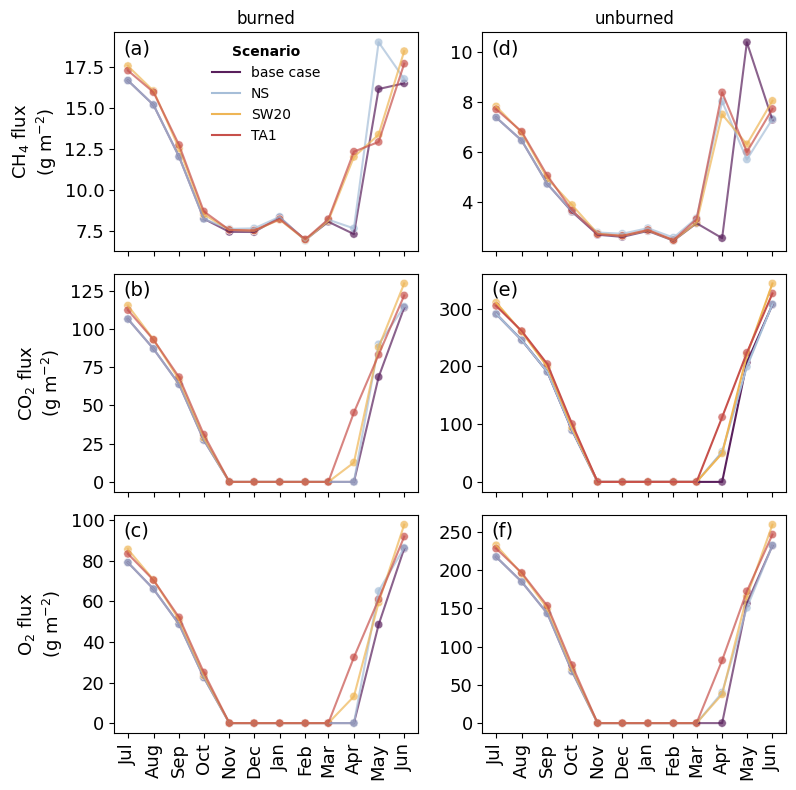

In [35]:
pond='burned'

pal = sns.color_palette(['#591f5c', '#A6BED8', '#EEB555', '#C7504B'])
fig, axes = plt.subplots(3, 2, figsize=(8,8), sharex=True)

sns.lineplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='tot_ch4_flux', hue='run', palette=pal, ax=axes[0,0], alpha=0.7)
sns.scatterplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='tot_ch4_flux', hue='run', palette=pal, ax=axes[0,0], legend=False, alpha=0.7)
#sns.barplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month', y='tot_ch4_flux', hue='run', palette=pal, ax=axes[0])

legend=axes[0,0].legend(title='Scenario', frameon=False, title_fontproperties={'weight':'bold'}, loc='upper center')

new_labels = ['base case', 'NS', 'SW20', 'TA1']
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
axes[0,0].set_ylabel(u'$\mathregular{CH_4}$ flux\n(g $\mathregular{m^{-2}}$)', fontsize=13)
axes[0,0].set_xlabel('')
axes[0,0].tick_params(axis='both', which='major', labelsize=13)
axes[0,0].set_title('burned')
axes[0,0].text(0.03, 0.9,'(a)', transform=axes[0,0].transAxes, fontsize=14)

sns.lineplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='tot_co2_flux', hue='run', palette=pal, ax=axes[1,0], alpha=0.7)
sns.scatterplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='tot_co2_flux', hue='run', palette=pal, ax=axes[1,0], legend=False, alpha=0.7)
axes[1,0].set_ylabel(u'$\mathregular{CO_2}$ flux\n(g $\mathregular{m^{-2}}$)', fontsize=13)
axes[1,0].set_xlabel('')
axes[1,0].tick_params(axis='both', which='major', labelsize=13)
legend=axes[1,0].legend()
legend.remove()
axes[1,0].text(0.03, 0.9,'(b)', transform=axes[1,0].transAxes, fontsize=14)


sns.lineplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='tot_o2_flux', hue='run', palette=pal, ax=axes[2,0], alpha=0.7)
sns.scatterplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='tot_o2_flux', hue='run', palette=pal, ax=axes[2,0], alpha=0.7)
axes[2,0].set_ylabel(u'$\mathregular{O_2}$ flux\n(g $\mathregular{m^{-2}}$)', fontsize=13)
axes[2,0].set_xlabel('')
axes[2,0].tick_params(axis='both', which='major', labelsize=13)
legend=axes[2,0].legend()
legend.remove()
axes[2,0].text(0.03, 0.9,'(c)', transform=axes[2,0].transAxes, fontsize=14)

pond='unburned'

sns.lineplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='tot_ch4_flux', hue='run', palette=pal, ax=axes[0,1], alpha=0.7)
sns.scatterplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='tot_ch4_flux', hue='run', palette=pal, ax=axes[0,1], legend=False, alpha=0.7)
axes[0,1].set_ylabel('', fontsize=13)
axes[0,1].set_xlabel('')
axes[0,1].tick_params(axis='both', which='major', labelsize=13)
legend=axes[0,1].legend()
legend.remove()
axes[0,1].set_title('unburned')
axes[0,1].text(0.03, 0.9,'(d)', transform=axes[0,1].transAxes, fontsize=14)

sns.lineplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='tot_co2_flux', hue='run', palette=pal, ax=axes[1,1])
sns.scatterplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='tot_co2_flux', hue='run', palette=pal, ax=axes[1,1], legend=False, alpha=0.7)
axes[1,1].set_ylabel('', fontsize=13)
axes[1,1].set_xlabel('')
axes[1,1].tick_params(axis='both', which='major', labelsize=13)
legend=axes[1,1].legend()
legend.remove()
axes[1,1].text(0.03, 0.9,'(e)', transform=axes[1,1].transAxes, fontsize=14)


sns.lineplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='tot_o2_flux', hue='run', palette=pal, ax=axes[2,1], alpha=0.7)
sns.scatterplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='tot_o2_flux', hue='run', palette=pal, ax=axes[2,1], alpha=0.7)
axes[2,1].set_ylabel('')
axes[2,1].set_xlabel('')
axes[2,1].tick_params(axis='both', which='major', labelsize=13)
legend=axes[2,1].legend()
legend.remove()
axes[2,1].text(0.03, 0.9,'(f)', transform=axes[2,1].transAxes, fontsize=14)

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
fig.autofmt_xdate(rotation=90, ha='center')

#plt.xlim(pd.to_datetime('2022-06-01'), pd.to_datetime('2023-06-30'))

fig.tight_layout()
plt.savefig('monthly_gas_fluxes.jpg', dpi=300)

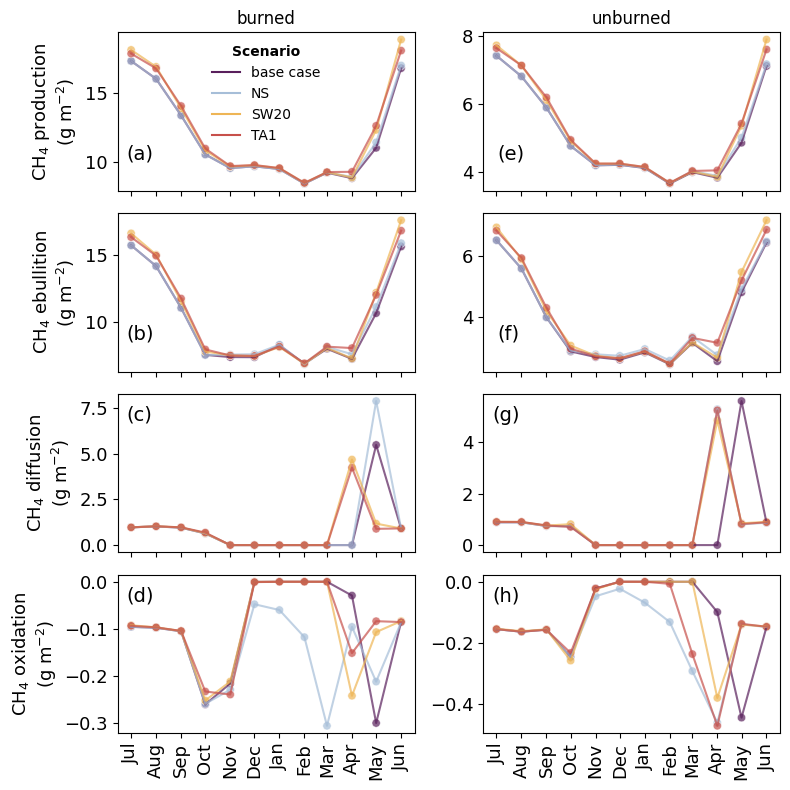

In [36]:
pond='burned'

pal = sns.color_palette(['#591f5c', '#A6BED8', '#EEB555', '#C7504B'])
fig, axes = plt.subplots(4, 2, figsize=(8,8), sharex=True)

sns.lineplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='methane_prod_young_mg/(m**2*day)', hue='run', palette=pal, ax=axes[0,0], alpha=0.7)
sns.scatterplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='methane_prod_young_mg/(m**2*day)', hue='run', palette=pal, ax=axes[0,0], legend=False, alpha=0.7)
#sns.barplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month', y='tot_ch4_flux', hue='run', palette=pal, ax=axes[0])

legend=axes[0,0].legend(title='Scenario', frameon=False, title_fontproperties={'weight':'bold'}, loc='upper center')

new_labels = ['base case', 'NS', 'SW20', 'TA1']
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
axes[0,0].set_ylabel(u'$\mathregular{CH_4}$ production\n(g $\mathregular{m^{-2}}$)', fontsize=13)
axes[0,0].set_xlabel('')
axes[0,0].tick_params(axis='both', which='major', labelsize=13)
axes[0,0].text(0.03, 0.2,'(a)', transform=axes[0,0].transAxes, fontsize=14)
axes[0,0].set_title('burned')

sns.lineplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='methane_ebul_mg/(m**2*day)', hue='run', palette=pal, ax=axes[1,0], alpha=0.7)
sns.scatterplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='methane_ebul_mg/(m**2*day)', hue='run', palette=pal, ax=axes[1,0], legend=False, alpha=0.7)
axes[1,0].set_ylabel(u'$\mathregular{CH_4}$ ebullition\n(g $\mathregular{m^{-2}}$)', fontsize=13)
axes[1,0].set_xlabel('')
axes[1,0].tick_params(axis='both', which='major', labelsize=13)
legend=axes[1,0].legend()
legend.remove()
axes[1,0].text(0.03, 0.2,'(b)', transform=axes[1,0].transAxes, fontsize=14)


sns.lineplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='methane_turb_flux_mg/(m**2*day)', hue='run', palette=pal, ax=axes[2,0], alpha=0.7)
sns.scatterplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='methane_turb_flux_mg/(m**2*day)', hue='run', palette=pal, ax=axes[2,0], alpha=0.7)
axes[2,0].set_ylabel(u'$\mathregular{CH_4}$ diffusion\n(g $\mathregular{m^{-2}}$)', fontsize=13)
axes[2,0].set_xlabel('')
axes[2,0].tick_params(axis='both', which='major', labelsize=13)
legend=axes[2,0].legend()
legend.remove()
axes[2,0].text(0.03, 0.83,'(c)', transform=axes[2,0].transAxes, fontsize=14)

sns.lineplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='methane_oxid_mg/(m**2*day)', hue='run', palette=pal, ax=axes[3,0], alpha=0.7)
sns.scatterplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='methane_oxid_mg/(m**2*day)', hue='run', palette=pal, ax=axes[3,0], alpha=0.7)
axes[3,0].set_ylabel(u'$\mathregular{CH_4}$ oxidation\n(g $\mathregular{m^{-2}}$)', fontsize=13)
axes[3,0].set_xlabel('')
axes[3,0].tick_params(axis='both', which='major', labelsize=13)
legend=axes[3,0].legend()
legend.remove()
axes[3,0].text(0.03, 0.83,'(d)', transform=axes[3,0].transAxes, fontsize=14)

pond='unburned'

sns.lineplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='methane_prod_young_mg/(m**2*day)', hue='run', palette=pal, ax=axes[0,1], alpha=0.7)
sns.scatterplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='methane_prod_young_mg/(m**2*day)', hue='run', palette=pal, ax=axes[0,1], legend=False, alpha=0.7)
axes[0,1].set_ylabel('', fontsize=13)
axes[0,1].set_xlabel('')
axes[0,1].tick_params(axis='both', which='major', labelsize=13)
legend=axes[0,1].legend()
legend.remove()
axes[0,1].text(0.05, 0.2,'(e)', transform=axes[0,1].transAxes, fontsize=14)
axes[0,1].set_title('unburned')

sns.lineplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='methane_ebul_mg/(m**2*day)', hue='run', palette=pal, ax=axes[1,1], alpha=0.7)
sns.scatterplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='methane_ebul_mg/(m**2*day)', hue='run', palette=pal, ax=axes[1,1], legend=False, alpha=0.7)
axes[1,1].set_ylabel('', fontsize=13)
axes[1,1].set_xlabel('')
axes[1,1].tick_params(axis='both', which='major', labelsize=13)
legend=axes[1,1].legend()
legend.remove()
axes[1,1].text(0.05, 0.2,'(f)', transform=axes[1,1].transAxes, fontsize=14)


sns.lineplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='methane_turb_flux_mg/(m**2*day)', hue='run', palette=pal, ax=axes[2,1], alpha=0.7)
sns.scatterplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='methane_turb_flux_mg/(m**2*day)', hue='run', palette=pal, ax=axes[2,1], alpha=0.7)
axes[2,1].set_ylabel('')
axes[2,1].set_xlabel('')
axes[2,1].tick_params(axis='both', which='major', labelsize=13)
legend=axes[2,1].legend()
legend.remove()
axes[2,1].text(0.03, 0.83,'(g)', transform=axes[2,1].transAxes, fontsize=14)


sns.lineplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='methane_oxid_mg/(m**2*day)', hue='run', palette=pal, ax=axes[3,1], alpha=0.7)
sns.scatterplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']==pond], x='month_dt', y='methane_oxid_mg/(m**2*day)', hue='run', palette=pal, ax=axes[3,1], alpha=0.7)
axes[3,1].set_ylabel('')
axes[3,1].set_xlabel('')
axes[3,1].tick_params(axis='both', which='major', labelsize=13)
legend=axes[3,1].legend()
legend.remove()
axes[3,1].text(0.03, 0.83,'(h)', transform=axes[3,1].transAxes, fontsize=14)

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)


fig.autofmt_xdate(rotation=90, ha='center')

#plt.xlim(pd.to_datetime('2022-06-01'), pd.to_datetime('2023-06-30'))

fig.tight_layout()
plt.savefig('ch4_component_comp.jpg', dpi=300)

In [37]:
df_t_fluxes.columns

Index(['year', 'month', 'day', 'hour', 'integration_time',
       'surface temperature, C', 'water skin temperature, C',
       'water surface temperature, C', 'mean temperature of water coloumn, C',
       'maximal temperature in the water coloumn, C',
       'zero-dimensional model temperature, C',
       'upper ice surface temperature, C', 'upper snow surface temperature, C',
       'sensible heat flux,    W/m**2', 'latent heat flux,      W/m**2',
       'downward heat flux at the upper lake surface, W/m**2',
       'downward heat flux at the lake bottom, W/m**2',
       'friction velocity at the surface (waterside), m/s',
       'friction velocity at the bottom, m/s',
       'wind work at the water surface, W/m**2',
       'albedo of the lake-atmosphere interface, n/d',
       'shortwave radiation penetrated below surface, W/m**2',
       'significant wave height, m', 'bottom ice salinity, kg/kg',
       'discharge in x direction, m**3/s', 'discharge in y direction, m**3/s',
      

In [38]:
df_t_fluxes['run'].unique()

array(['5yr', 'nosnow5yr', 'swin20pct5yr', 'tplus1pct5yr'], dtype=object)

In [39]:
df_methanes.columns

Index(['Date', 'year', 'month', 'day', 'hour', 'talik depth, m',
       'lake surface methane concentration, mol/m**3',
       'lake bottom methane concentration, mol/m**3',
       'methane_prod_young_mol/(m**2*s)', 'methane_prod_old_mol/(m**2*s)',
       'methane_diffuse_bot_mol/(m**2*s)', 'methane_ebul_mol/(m**2*s)',
       'methane_ebul_mg/(m**2*day)', 'methane_turb_flux_mol/(m**2*s)',
       'methane_turb_flux_mg/(m**2*day)', 'methane_oxid_mg/(m**2*day)',
       'methane_plant_med_flux_mg/(m**2*day)', 'co2_turb_flux_mol/(m**2*s)',
       'co2_ebul_mol/(m**2*s)', 'ox_turb_flux_mol/(m**2*s)',
       'ox_ebul_mol/(m**2*s)', 'methane_ebul_sc1', 'methane_ebul_sc2',
       'methane_ebul_sc3', 'methane_ebul_sc4', 'methane_ebul_sc5', 'run_name',
       'pond', 'run', 'ice layer thickness,   m', 'snow layer thickness,  m',
       'month_dt', 'co2_turb_flux_mg/(m**2*day)', 'co2_ebul_mg/(m**2*day)',
       'ox_turb_flux_mg/(m**2*day)', 'ox_ebul_mg/(m**2*day)', 'tot_ch4_flux',
       'tot_co2_

(0.0, 2e-06)

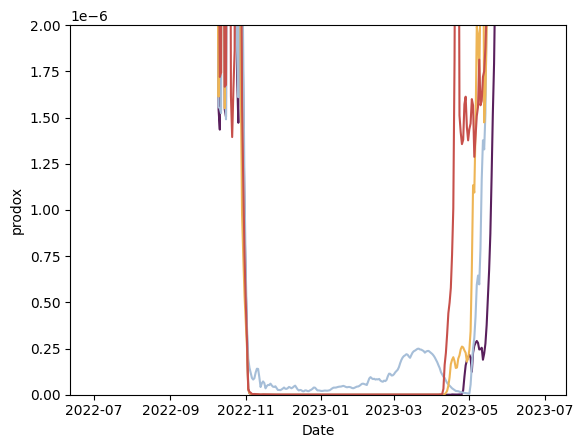

In [40]:
fig, ax = plt.subplots()
sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='prodox', hue='run', ax = ax, legend=False, palette=pal)

ax.set_ylim(0,0.000002)

(0.0, 1e-07)

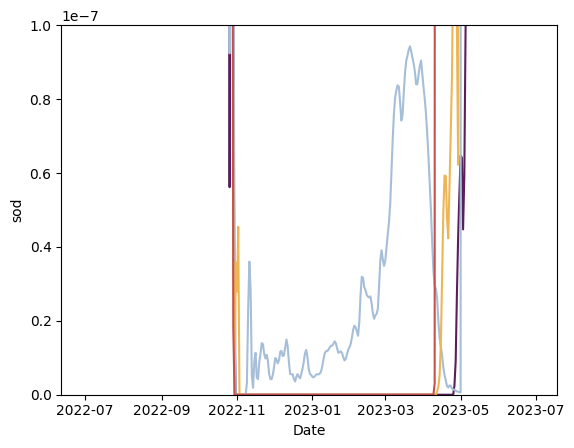

In [41]:
fig, ax = plt.subplots()
sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='sod', hue='run', ax = ax, legend=False, palette=pal)

ax.set_ylim(0,0.0000001)


(0.0, 0.1)

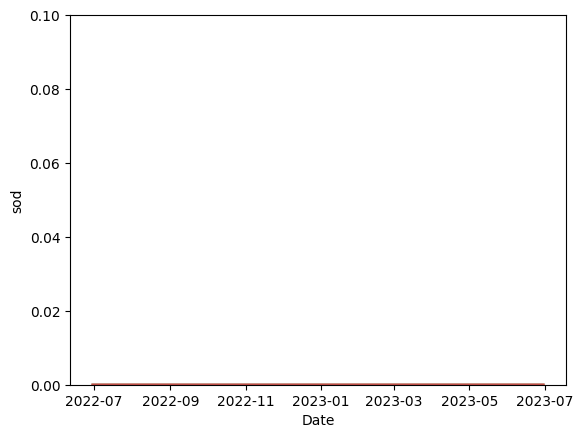

In [42]:
fig, ax = plt.subplots()
sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='sod', hue='run', ax = ax, legend=False, palette=pal)
plt.ylim(0,0.1)


(0.0, 0.05)

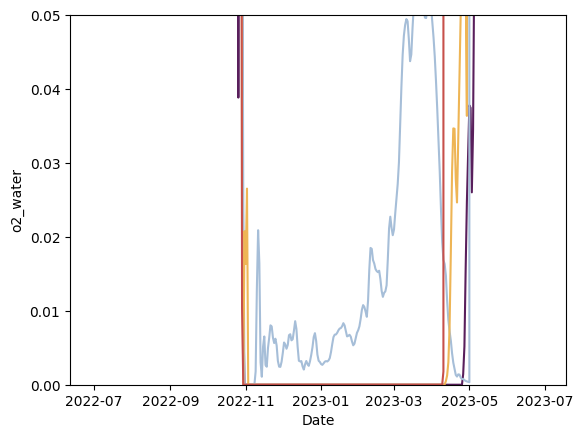

In [43]:
fig, ax = plt.subplots()
sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='o2_water', hue='run', ax = ax, legend=False, palette=pal)

ax.set_ylim(0,0.05)

(160.0, 180.0)

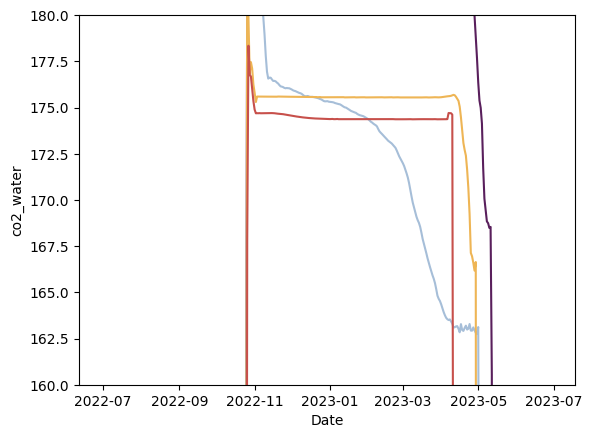

In [44]:
fig, ax = plt.subplots()
sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='co2_water', hue='run', ax = ax, legend=False, palette=pal)

ax.set_ylim(160,180)

<Axes: xlabel='Date', ylabel='pocl_water'>

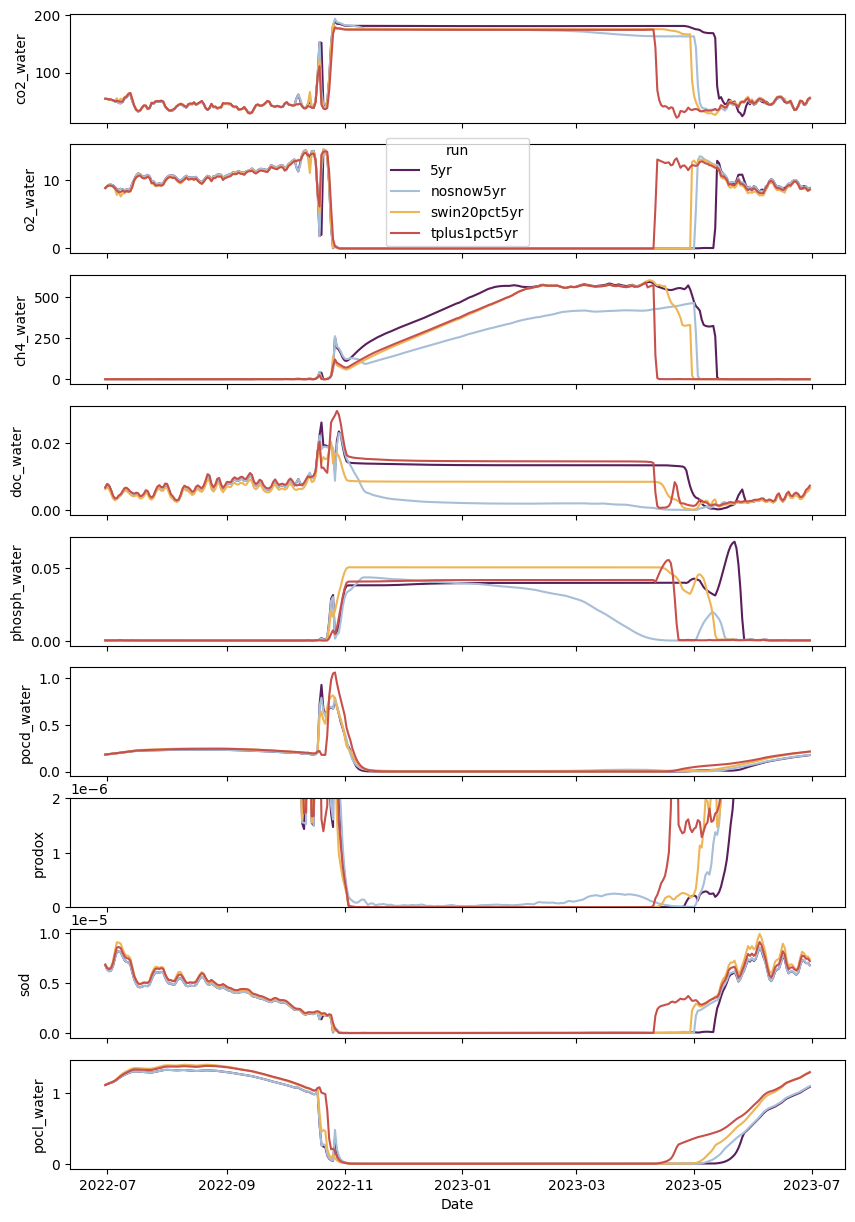

In [45]:
#full biogeochem data for burned

fig, axes = plt.subplots(9, 1,figsize=(10,15), sharex=True)

sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='co2_water', hue='run', ax = axes[0], legend=False, palette=pal)
sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='o2_water', hue='run', ax = axes[1], palette=pal)
sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='ch4_water', hue='run', ax = axes[2], legend=False, palette=pal)
#axes[2].set_ylim(0,2)
sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='doc_water', hue='run', ax = axes[3], legend=False, palette=pal)

#axes[4].set_ylim(0,10)
sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='phosph_water', hue='run', ax = axes[4], legend=False, palette=pal)

sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='pocd_water', hue='run', ax = axes[5], legend=False, palette=pal)

#axes[5].set_ylim(0,40)

sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='prodox', hue='run', ax = axes[6], legend=False, palette=pal)

axes[6].set_ylim(0,0.000002)

sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='sod', hue='run', ax = axes[7], legend=False, palette=pal)

sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='pocl_water', hue='run', ax = axes[8], legend=False, palette=pal)
#axes[8].set_ylim(0,.1)


(19174.0, 19539.0)

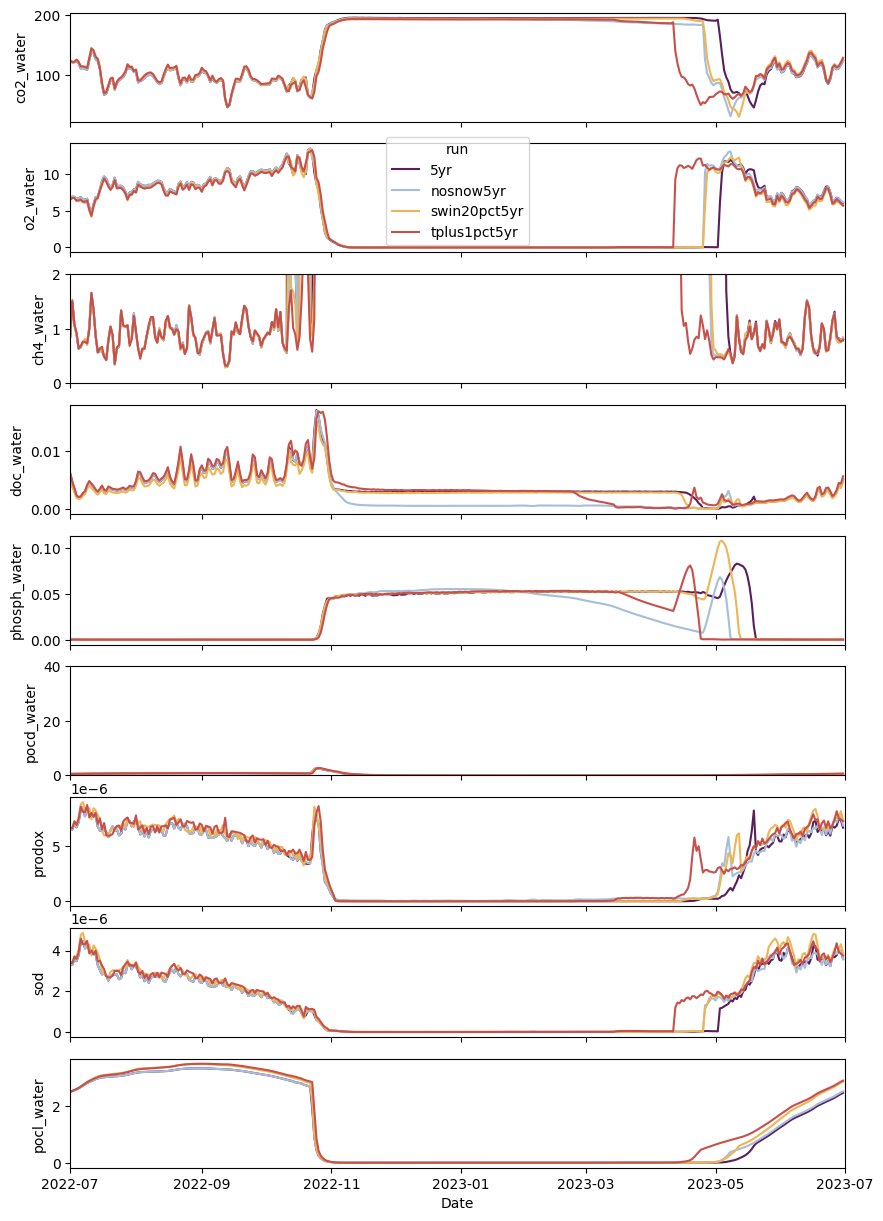

In [46]:
# full biogeochem data for unburned

pond_name='unburned'
fig, axes = plt.subplots(9, 1,figsize=(10,15), sharex=True)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='co2_water', hue='run', ax = axes[0], legend=False, palette=pal)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='o2_water', hue='run', ax = axes[1], palette=pal)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='ch4_water', hue='run', ax = axes[2], legend=False, palette=pal)
axes[2].set_ylim(0,2)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='doc_water', hue='run', ax = axes[3], legend=False, palette=pal)

#axes[4].set_ylim(0,10)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='phosph_water', hue='run', ax = axes[4], legend=False, palette=pal)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='pocd_water', hue='run', ax = axes[5], legend=False, palette=pal)

axes[5].set_ylim(0,40)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='prodox', hue='run', ax = axes[6], legend=False, palette=pal)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='sod', hue='run', ax = axes[7], legend=False, palette=pal)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='pocl_water', hue='run', ax = axes[8], legend=False, palette=pal)
plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-07-01'))

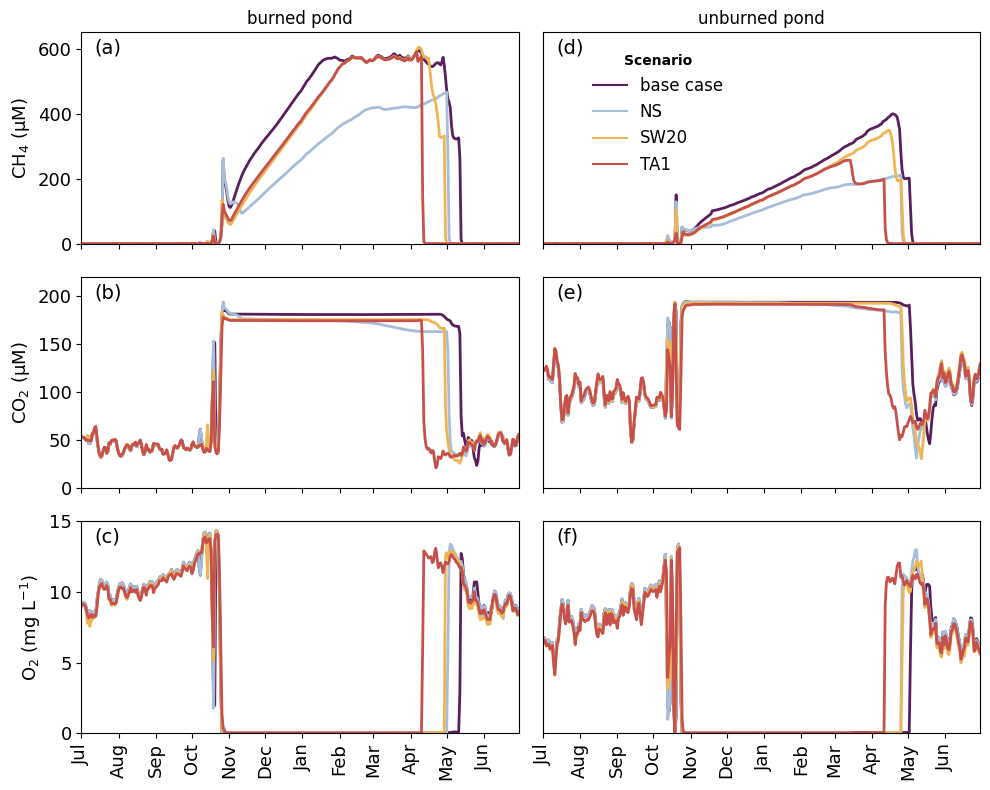

In [47]:
#main gas concentration plots
fig, axes = plt.subplots(3, 2,figsize=(10,8), sharex=True)

#Burned plots
pond_name='burned'
sns.lineplot(data= df_results.loc[df_results['pond']==pond_name], 
        x='Date', y='ch4_water', hue='run', ax = axes[0,0],linewidth=2, palette=pal, legend=False)

axes[0,0].set_ylabel(u'$\mathregular{CH_4}$ (\u03bcM)', fontsize=13)
axes[0,0].set_xlabel('')
axes[0,0].set_ylim(0, 650)
axes[0,0].xaxis.set_tick_params(rotation=20)
axes[0,0].text(0.03, 0.9,'(a)', transform=axes[0,0].transAxes, fontsize=14)
axes[0,0].set_title(pond_name+' pond')

sns.lineplot(data= df_results.loc[df_results['pond']==pond_name], 
        x='Date', y='co2_water', hue='run', ax = axes[1,0], legend=False,linewidth=2, palette=pal)
axes[1,0].set_ylabel(u'$\mathregular{CO_2}$ (\u03bcM)', fontsize=13)
axes[1,0].set_ylim(0, 220)
axes[1,0].text(0.03, 0.9,'(b)', transform=axes[1,0].transAxes, fontsize=14)

#fig.suptitle(pond_name+' pond') 
sns.lineplot(data= df_results.loc[df_results['pond']==pond_name], 
        x='Date', y='o2_water', hue='run', ax = axes[2,0], legend=False,linewidth=2, palette=pal)
axes[2,0].set_ylabel('$\mathregular{O_2}$ (mg $\mathregular{L^{-1}}$)', fontsize=13)
axes[2,0].set_xlabel('')
axes[2,0].set_ylim(0, 15)
axes[2,0].text(0.03, 0.9,'(c)', transform=axes[2,0].transAxes, fontsize=14)

# Unburned plots
pond_name='unburned'

sns.lineplot(data= df_results.loc[df_results['pond']==pond_name], 
        x='Date', y='ch4_water', hue='run', ax = axes[0,1],linewidth=2, palette=pal)
axes[0,1].set_ylabel('')
axes[0,1].set_xlabel('')
axes[0,1].get_yaxis().set_visible(False)
axes[0,1].set_ylim(0, 650)
axes[0,1].text(0.03, 0.9,'(d)', transform=axes[0,1].transAxes, fontsize=14)
axes[0,1].set_title(pond_name+' pond')

sns.lineplot(data= df_results.loc[df_results['pond']==pond_name], 
        x='Date', y='co2_water', hue='run', ax = axes[1,1], legend=False,linewidth=2, palette=pal)
axes[1,1].set_ylabel('')
axes[1,1].get_yaxis().set_visible(False)
axes[1,1].set_ylim(0, 220)
axes[1,1].text(0.03, 0.9,'(e)', transform=axes[1,1].transAxes, fontsize=14)

sns.lineplot(data= df_results.loc[df_results['pond']==pond_name], 
        x='Date', y='o2_water', hue='run', ax = axes[2,1], legend=False,linewidth=2, palette=pal)
axes[2,1].set_ylabel('')
axes[2,1].set_xlabel('')
axes[2,1].get_yaxis().set_visible(False)
axes[2,1].set_ylim(0, 15)
axes[2,1].text(0.03, 0.9,'(f)', transform=axes[2,1].transAxes, fontsize=14)

plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-06-30'))
axes[2,1].xaxis.set_tick_params(rotation=20)

#legend1 = axes[2,0].legend().remove()

legend=axes[0,1].legend(title='Scenario', frameon=False, title_fontproperties={'weight':'bold'}, loc=(0.1,0.3), fontsize=12)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)

axes[0,0].tick_params(axis='both', which='major', labelsize=13)
axes[1,0].tick_params(axis='both', which='major', labelsize=13)
axes[2,0].tick_params(axis='both', which='major', labelsize=13)
axes[2,1].tick_params(axis='both', which='major', labelsize=13)

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)


fig.autofmt_xdate(rotation=90, ha='center')

fig.tight_layout()

plt.savefig('met_exp-concentration_comp.jpg', dpi=300)

In [48]:
df_results.columns

Index(['year', 'month', 'day', 'hour', 'integration_time', 'depth',
       'water_temp', 'Date', 'co2_water', 'ch4_water', 'o2_water', 'doc_water',
       'pocl_water', 'pocd_water', 'phosph_water', 'prodox', 'sod', 'pond',
       'run', 'ice layer thickness,   m', 'snow layer thickness,  m',
       'month_dt'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


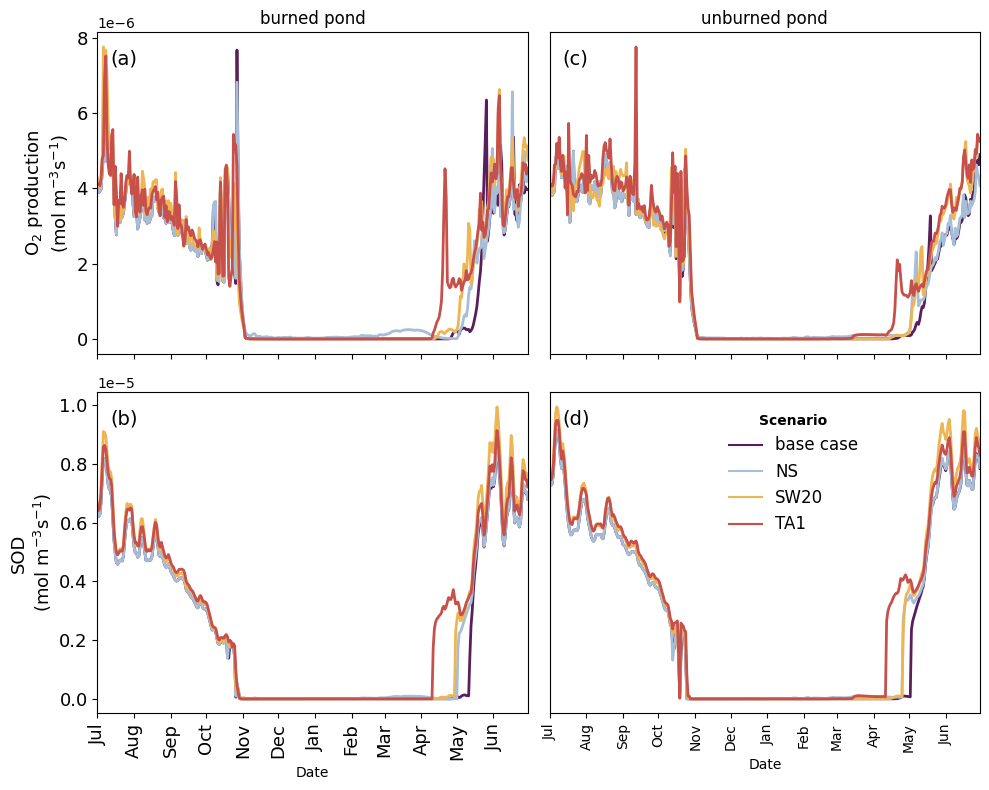

In [49]:
#main gas concentration plots
fig, axes = plt.subplots(2, 2,figsize=(10,8), sharex=True)

#Burned plots
pond_name='burned'
#fig.suptitle(pond_name+' pond') 
sns.lineplot(data= df_results.loc[df_results['pond']==pond_name], 
        x='Date', y='prodox', hue='run', ax = axes[0,0], legend=False,linewidth=2, palette=pal)
axes[0,0].set_title(pond_name+' pond')
axes[0,0].set_ylabel('$\mathregular{O_2}$ production\n(mol $\mathregular{m^{-3}} \mathregular{s^{-1}}$)', fontsize=13)
#axes[0,0].set_ylim(0, 15)
axes[0,0].text(0.03, 0.9,'(a)', transform=axes[0,0].transAxes, fontsize=14)

sns.lineplot(data= df_results.loc[df_results['pond']==pond_name], 
        x='Date', y='sod', hue='run', ax = axes[1,0], legend=False,linewidth=2, palette=pal)
axes[1,0].set_ylabel('SOD\n(mol $\mathregular{m^{-3}} \mathregular{s^{-1}}$)', fontsize=13)
#axes[1,0].set_ylim(0, 220)
axes[1,0].text(0.03, 0.9,'(b)', transform=axes[1,0].transAxes, fontsize=14)

# Unburned plots
pond_name='unburned'
sns.lineplot(data= df_results.loc[df_results['pond']==pond_name], 
        x='Date', y='prodox', hue='run', ax = axes[0,1], legend=False,linewidth=2, palette=pal)
axes[0,1].set_title(pond_name+' pond')
axes[0,1].set_ylabel('')
axes[0,1].get_yaxis().set_visible(False)
#axes[0,1].set_ylim(0, 15)
axes[0,1].text(0.03, 0.9,'(c)', transform=axes[0,1].transAxes, fontsize=14)

sns.lineplot(data= df_results.loc[df_results['pond']==pond_name], 
        x='Date', y='sod', hue='run', ax = axes[1,1], linewidth=2, palette=pal)
axes[1,1].set_ylabel('')
axes[1,1].get_yaxis().set_visible(False)
#axes[1,1].set_ylim(0, 220)
axes[1,1].text(0.03, 0.9,'(d)', transform=axes[1,1].transAxes, fontsize=14)

plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-06-30'))
axes[1,1].xaxis.set_tick_params(rotation=20)

legend1 = axes[1,0].legend().remove()
new_labels = ['base case', 'NS', 'SW20', 'TA1']

legend=axes[1,1].legend(title='Scenario', frameon=False, title_fontproperties={'weight':'bold'}, loc=(0.4,0.54), fontsize=12)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)

axes[0,0].tick_params(axis='both', which='major', labelsize=13)
axes[1,0].tick_params(axis='both', which='major', labelsize=13)

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)


fig.autofmt_xdate(rotation=90, ha='center')

fig.tight_layout()

plt.savefig('met_exp-co2-prodcons.jpg', dpi=300)

# Summer box plots

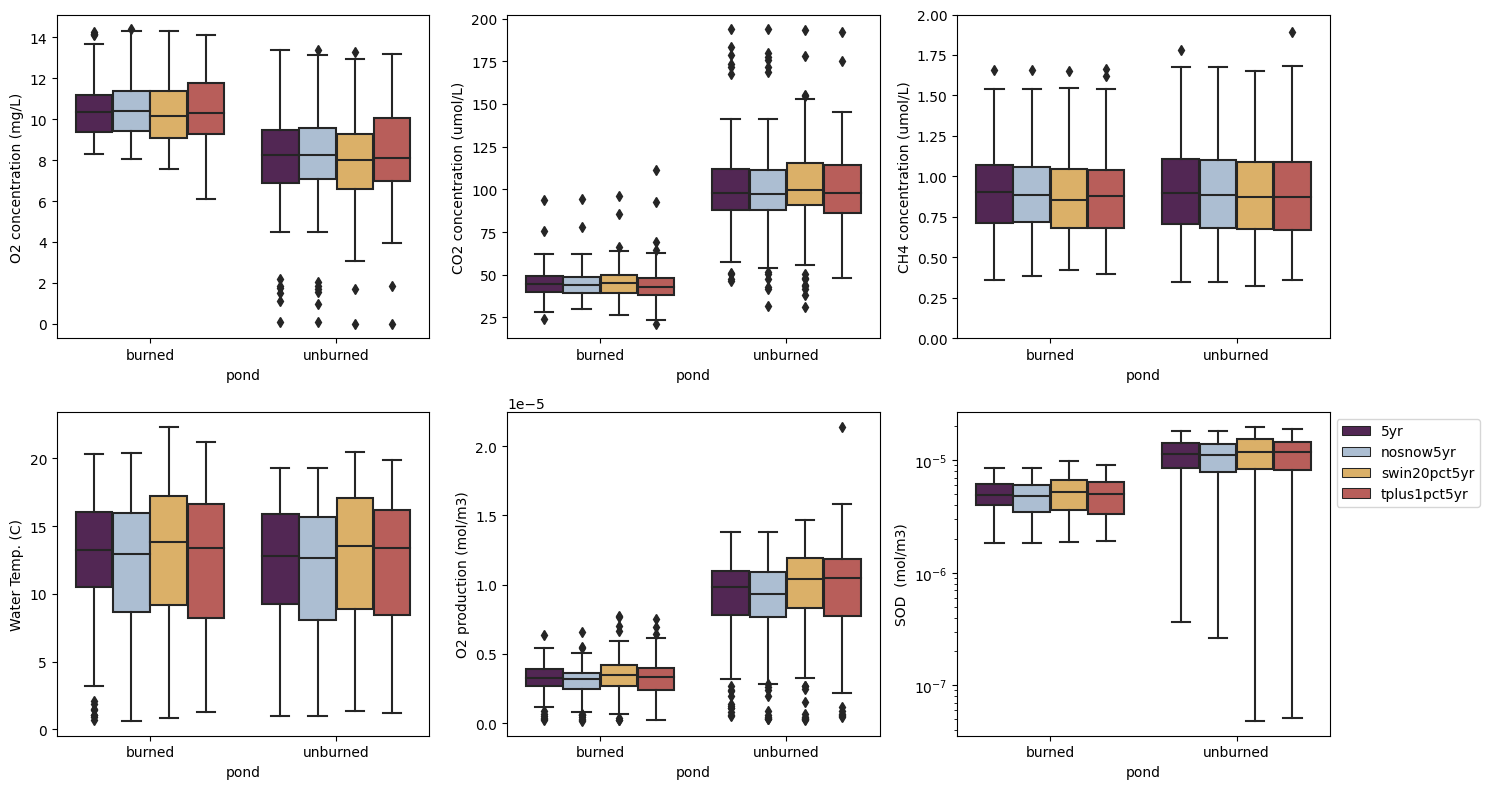

In [50]:
fig, axes=plt.subplots(2,3, figsize=(15,8))
sns.boxplot(data=ice_free_box_data.loc[ice_free_box_data['variable'] == 'o2_water'], 
            x='pond', y='value', hue='run', ax=axes[0,0], palette=pal)
#axes[0,0].legend(title='', loc='lower left')
axes[0,0].legend().remove()
axes[0,0].set_ylabel('O2 concentration (mg/L)')

sns.boxplot(data=ice_free_box_data.loc[ice_free_box_data['variable'] == 'co2_water'], 
            x='pond', y='value', hue='run', ax=axes[0,1], palette=pal)
axes[0,1].legend().remove()
axes[0,1].set_ylabel('CO2 concentration (umol/L)')

sns.boxplot(data=ice_free_box_data.loc[ice_free_box_data['variable'] == 'ch4_water'], 
            x='pond', y='value', hue='run', ax=axes[0,2], palette=pal)
axes[0,2].legend().remove()
axes[0,2].set_ylabel('CH4 concentration (umol/L)')
axes[0,2].set_ylim(0,2)

sns.boxplot(data=ice_free_box_data.loc[ice_free_box_data['variable'] == 'water_temp'], 
            x='pond', y='value', hue='run', ax=axes[1,0], palette=pal)
axes[1,0].legend().remove()
axes[1,0].set_ylabel('Water Temp. (C)')

sns.boxplot(data=ice_free_box_data.loc[ice_free_box_data['variable'] == 'prodox'], 
            x='pond', y='value', hue='run', ax=axes[1,1], palette=pal)
axes[1,1].legend().remove()
axes[1,1].set_ylabel('O2 production (mol/m3)')
#axes[1,1].set_yscale('log')

sns.boxplot(data=ice_free_box_data.loc[ice_free_box_data['variable'] == 'sod'], 
            x='pond', y='value', hue='run', ax=axes[1,2], palette=pal)

axes[1, 2].legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
axes[1,2].set_ylabel('SOD  (mol/m3)')
axes[1,2].set_yscale('log')
#axes[1,2].set_ylim(0,1e-6)

fig.tight_layout()
plt.savefig('met_exp_results_summer.jpg', dpi=300)

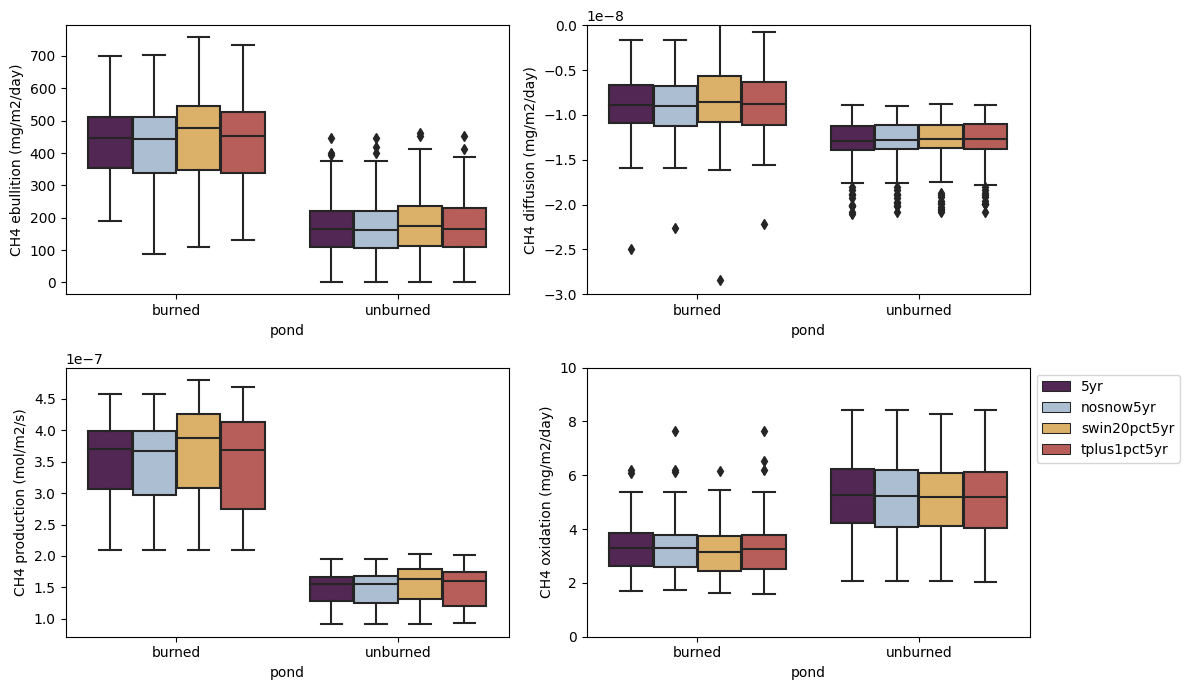

In [51]:
summer_box_data_ch4 = methane_comp_melt.loc[(methane_comp_melt['Date'].dt.month<=9) & (methane_comp_melt['Date'].dt.month>=6)]

fig, axes=plt.subplots(2,2, figsize=(12,7))
sns.boxplot(data=ice_free_ch4_data.loc[ice_free_ch4_data['variable'] == 'methane_ebul_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[0,0], palette=pal)
axes[0,0].legend().remove()
#axes[0,0].legend(title='', loc='lower left')
axes[0,0].set_ylabel('CH4 ebullition (mg/m2/day)')

sns.boxplot(data=ice_free_ch4_data.loc[ice_free_ch4_data['variable'] == 'methane_diffuse_bot_mol/(m**2*s)'], 
            x='pond', y='value', hue='run', ax=axes[0,1], palette=pal)
axes[0,1].legend().remove()
axes[0,1].set_ylabel('CH4 diffusion (mg/m2/day)')
axes[0,1].set_ylim(-.3e-7,0)

sns.boxplot(data=ice_free_ch4_data.loc[ice_free_ch4_data['variable'] == 'methane_prod_young_mol/(m**2*s)'], 
            x='pond', y='value', hue='run', ax=axes[1,0], palette=pal)
axes[1,0].legend().remove()
axes[1,0].set_ylabel('CH4 production (mol/m2/s)')
#axes[0,2].set_ylim(0,2)

sns.boxplot(data=ice_free_ch4_data.loc[ice_free_ch4_data['variable'] == 'methane_oxid_mg/(m**2*day)'], 
            x='pond', y=ice_free_ch4_data.loc[ice_free_ch4_data['variable'] == 'methane_oxid_mg/(m**2*day)']['value']*-1, hue='run', ax=axes[1,1], palette=pal)
#axes[1,1].legend().remove()
axes[1,1].legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
axes[1,1].set_ylabel('CH4 oxidation (mg/m2/day)')
axes[1,1].set_ylim(0,10)
#axes[1,1].set_yscale('log')

fig.tight_layout()
plt.savefig('met_exp_ch4_results_summer.jpg', dpi=300)

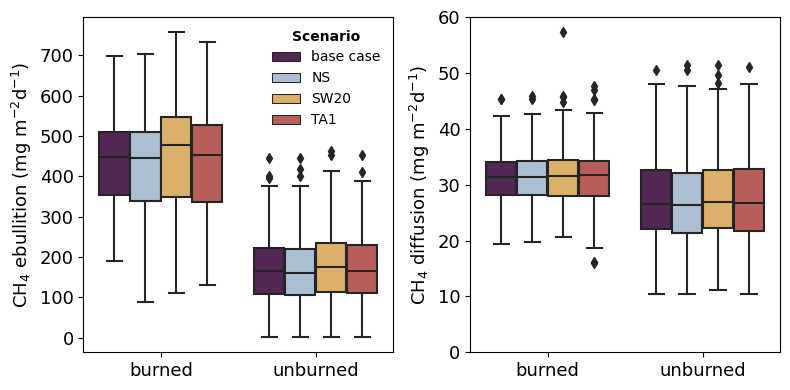

In [52]:
pal = sns.color_palette(['#591f5c', '#A6BED8', '#EEB555', '#C7504B'])
fig, axes=plt.subplots(1,2, figsize=(8,4))
sns.boxplot(data=ice_free_ch4_data.loc[ice_free_ch4_data['variable'] == 'methane_ebul_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[0], palette=pal)
axes[0].legend().remove()
#axes[0,0].legend(title='', loc='lower left')
axes[0].set_ylabel('CH4 ebullition (mg/m2/day)')
axes[0].set_xlabel('')
axes[0].tick_params(axis='both', which='major', labelsize=13)
legend=axes[0].legend(title='Scenario', frameon=False, title_fontproperties={'weight':'bold'}, loc='upper right')
new_labels = ['base case', 'NS', 'SW20', 'TA1']
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
axes[0].set_ylabel(u'$\mathregular{CH_4}$ ebullition (mg $\mathregular{m^{-2}} \mathregular{d^{-1}}$)', fontsize=13)

sns.boxplot(data=ice_free_ch4_data.loc[ice_free_ch4_data['variable'] == 'methane_turb_flux_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[1], palette=pal)
axes[1].legend().remove()
axes[1].set_ylabel(u'$\mathregular{CH_4}$ diffusion (mg $\mathregular{m^{-2}} \mathregular{d^{-1}}$)', fontsize=13)
axes[1].set_ylim(0, 60)
axes[1].set_xlabel('')
axes[1].tick_params(axis='both', which='major', labelsize=13)


fig.tight_layout()
plt.savefig('met_exp_ch4_results_summer.jpg', dpi=300)

In [53]:
df_methanes.columns

Index(['Date', 'year', 'month', 'day', 'hour', 'talik depth, m',
       'lake surface methane concentration, mol/m**3',
       'lake bottom methane concentration, mol/m**3',
       'methane_prod_young_mol/(m**2*s)', 'methane_prod_old_mol/(m**2*s)',
       'methane_diffuse_bot_mol/(m**2*s)', 'methane_ebul_mol/(m**2*s)',
       'methane_ebul_mg/(m**2*day)', 'methane_turb_flux_mol/(m**2*s)',
       'methane_turb_flux_mg/(m**2*day)', 'methane_oxid_mg/(m**2*day)',
       'methane_plant_med_flux_mg/(m**2*day)', 'co2_turb_flux_mol/(m**2*s)',
       'co2_ebul_mol/(m**2*s)', 'ox_turb_flux_mol/(m**2*s)',
       'ox_ebul_mol/(m**2*s)', 'methane_ebul_sc1', 'methane_ebul_sc2',
       'methane_ebul_sc3', 'methane_ebul_sc4', 'methane_ebul_sc5', 'run_name',
       'pond', 'run', 'ice layer thickness,   m', 'snow layer thickness,  m',
       'month_dt', 'co2_turb_flux_mg/(m**2*day)', 'co2_ebul_mg/(m**2*day)',
       'ox_turb_flux_mg/(m**2*day)', 'ox_ebul_mg/(m**2*day)', 'tot_ch4_flux',
       'tot_co2_

In [54]:
df_methanes.loc[(df_methanes['run']=='5yr') & 
                (df_methanes['ice layer thickness,   m']==0) & 
                (df_methanes['pond']=='burned'), 'methane_ebul_mg/(m**2*day)'].mean()

439.1209999999999

In [55]:
df_methanes.loc[(df_methanes['run']=='5yr') & 
                (df_methanes['ice layer thickness,   m']==0) & 
                (df_methanes['pond']=='burned'), 'methane_turb_flux_mg/(m**2*day)'].mean()

55.07711875

In [56]:
df_methanes.loc[(df_methanes['run']=='5yr') & 
                (df_methanes['ice layer thickness,   m']==0) & 
                (df_methanes['pond']=='unburned'), 'methane_ebul_mg/(m**2*day)'].mean()

172.8892346820809

In [57]:
df_methanes.loc[(df_methanes['run']=='5yr') & 
                (df_methanes['ice layer thickness,   m']==0) & 
                (df_methanes['pond']=='unburned'), 'methane_turb_flux_mg/(m**2*day)'].mean()

42.8411098265896

# Winter box plots

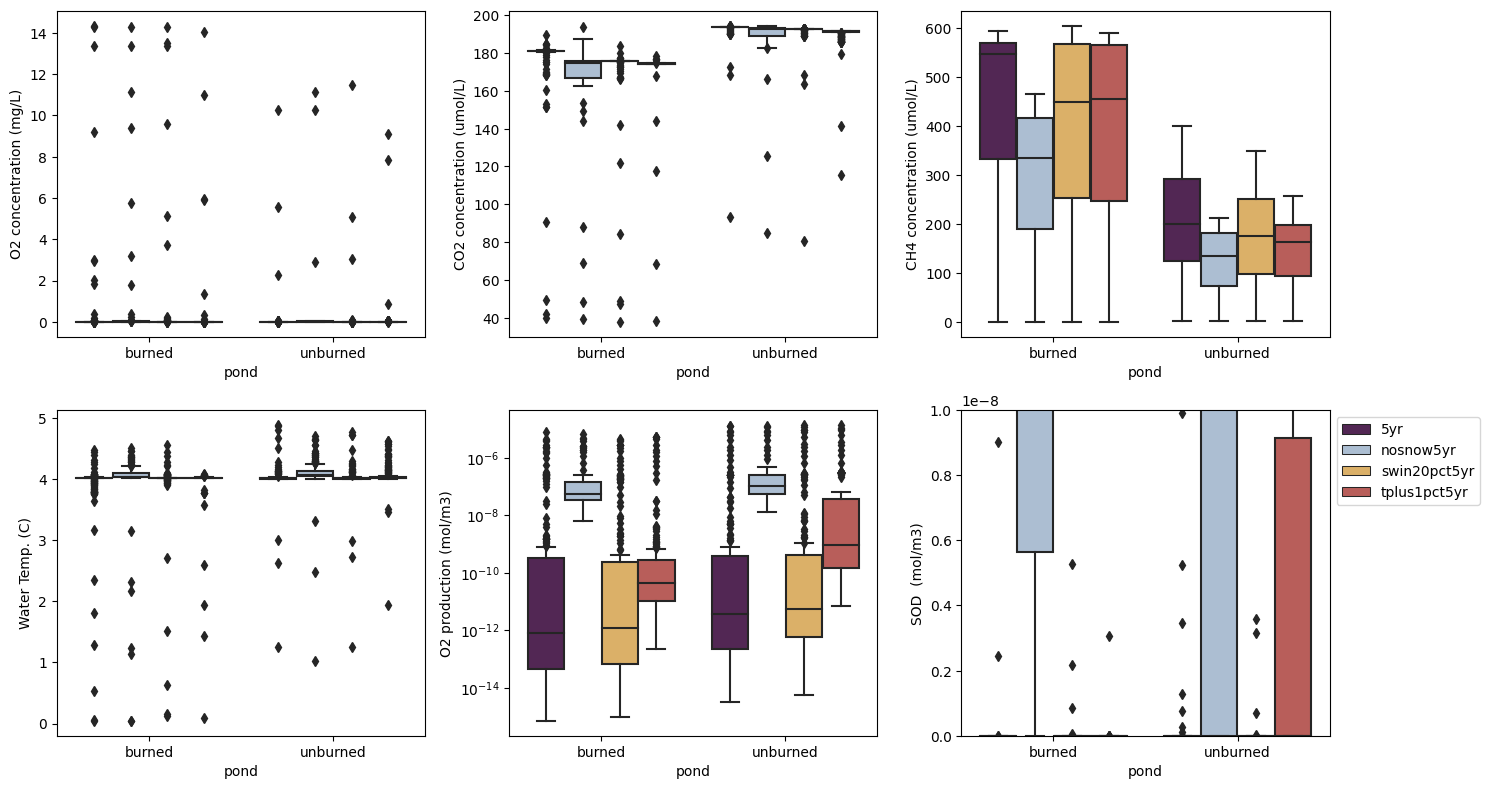

In [58]:
fig, axes=plt.subplots(2,3, figsize=(15,8))
sns.boxplot(data=ice_on_box_data.loc[ice_on_box_data['variable'] == 'o2_water'], 
            x='pond', y='value', hue='run', ax=axes[0,0], palette=pal)
#axes[0,0].legend(title='', loc='lower left')
axes[0,0].legend().remove()
axes[0,0].set_ylabel('O2 concentration (mg/L)')

sns.boxplot(data=ice_on_box_data.loc[ice_on_box_data['variable'] == 'co2_water'], 
            x='pond', y='value', hue='run', ax=axes[0,1], palette=pal)
axes[0,1].legend().remove()
axes[0,1].set_ylabel('CO2 concentration (umol/L)')

sns.boxplot(data=ice_on_box_data.loc[ice_on_box_data['variable'] == 'ch4_water'], 
            x='pond', y='value', hue='run', ax=axes[0,2], palette=pal)
axes[0,2].legend().remove()
axes[0,2].set_ylabel('CH4 concentration (umol/L)')
#axes[0,2].set_ylim(0,2)

sns.boxplot(data=ice_on_box_data.loc[ice_on_box_data['variable'] == 'water_temp'], 
            x='pond', y='value', hue='run', ax=axes[1,0], palette=pal)
axes[1,0].legend().remove()
axes[1,0].set_ylabel('Water Temp. (C)')

sns.boxplot(data=ice_on_box_data.loc[ice_on_box_data['variable'] == 'prodox'], 
            x='pond', y='value', hue='run', ax=axes[1,1], palette=pal)
axes[1,1].legend().remove()
axes[1,1].set_ylabel('O2 production (mol/m3)')
axes[1,1].set_yscale('log')

sns.boxplot(data=ice_on_box_data.loc[ice_on_box_data['variable'] == 'sod'], 
            x='pond', y='value', hue='run', ax=axes[1,2], palette=pal)

axes[1, 2].legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
axes[1,2].set_ylabel('SOD  (mol/m3)')
#axes[1,2].set_yscale('log')
axes[1,2].set_ylim(0,1e-8)

fig.tight_layout()
plt.savefig('met_exp_results_winter.jpg', dpi=300)

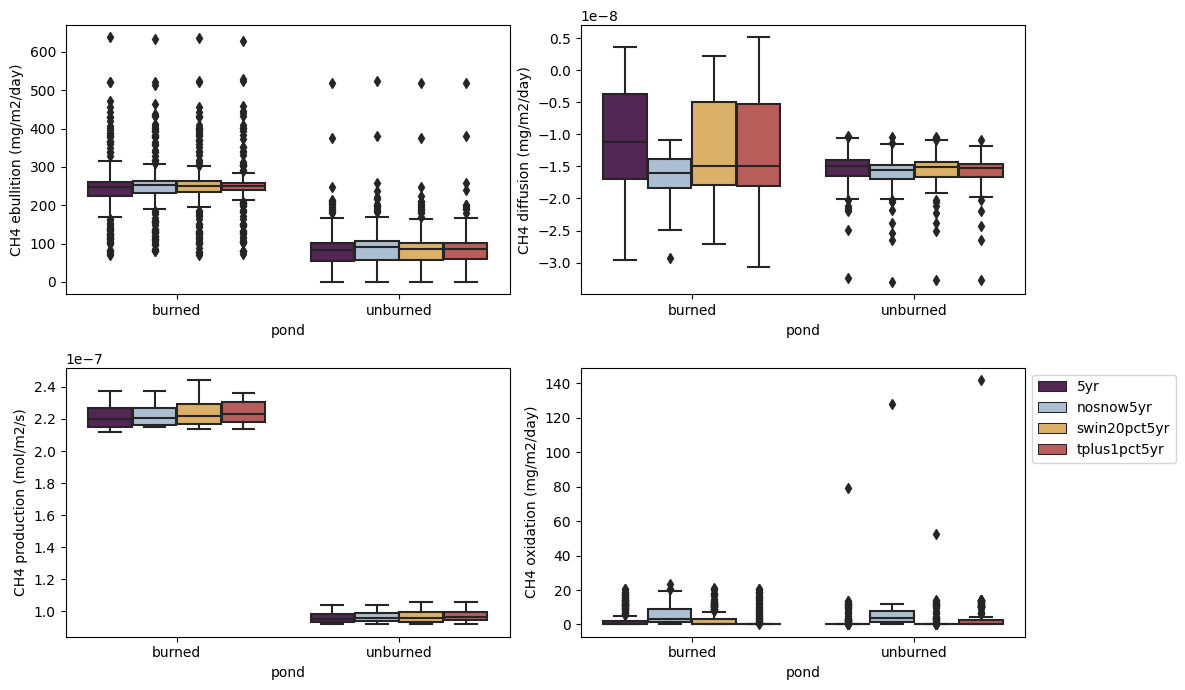

In [59]:
fig, axes=plt.subplots(2,2, figsize=(12,7))
sns.boxplot(data=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_ebul_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[0,0], palette=pal)
axes[0,0].legend().remove()
#axes[0,0].legend(title='', loc='lower left')
axes[0,0].set_ylabel('CH4 ebullition (mg/m2/day)')

sns.boxplot(data=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_diffuse_bot_mol/(m**2*s)'], 
            x='pond', y='value', hue='run', ax=axes[0,1], palette=pal)
axes[0,1].legend().remove()
axes[0,1].set_ylabel('CH4 diffusion (mg/m2/day)')
#axes[0,1].set_ylim(0,100)

sns.boxplot(data=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_prod_young_mol/(m**2*s)'], 
            x='pond', y='value', hue='run', ax=axes[1,0], palette=pal)
axes[1,0].legend().remove()
axes[1,0].set_ylabel('CH4 production (mol/m2/s)')
#axes[0,2].set_ylim(0,2)

sns.boxplot(data=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_oxid_mg/(m**2*day)'], 
            x='pond', y=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_oxid_mg/(m**2*day)']['value']*-1, hue='run', ax=axes[1,1], palette=pal)
#axes[1,1].legend().remove()
axes[1,1].legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
axes[1,1].set_ylabel('CH4 oxidation (mg/m2/day)')
#axes[1,1].set_ylim(0,1e-2)
#axes[1,1].set_yscale('log')

fig.tight_layout()
plt.savefig('met_exp_ch4_results_winter.jpg', dpi=300)

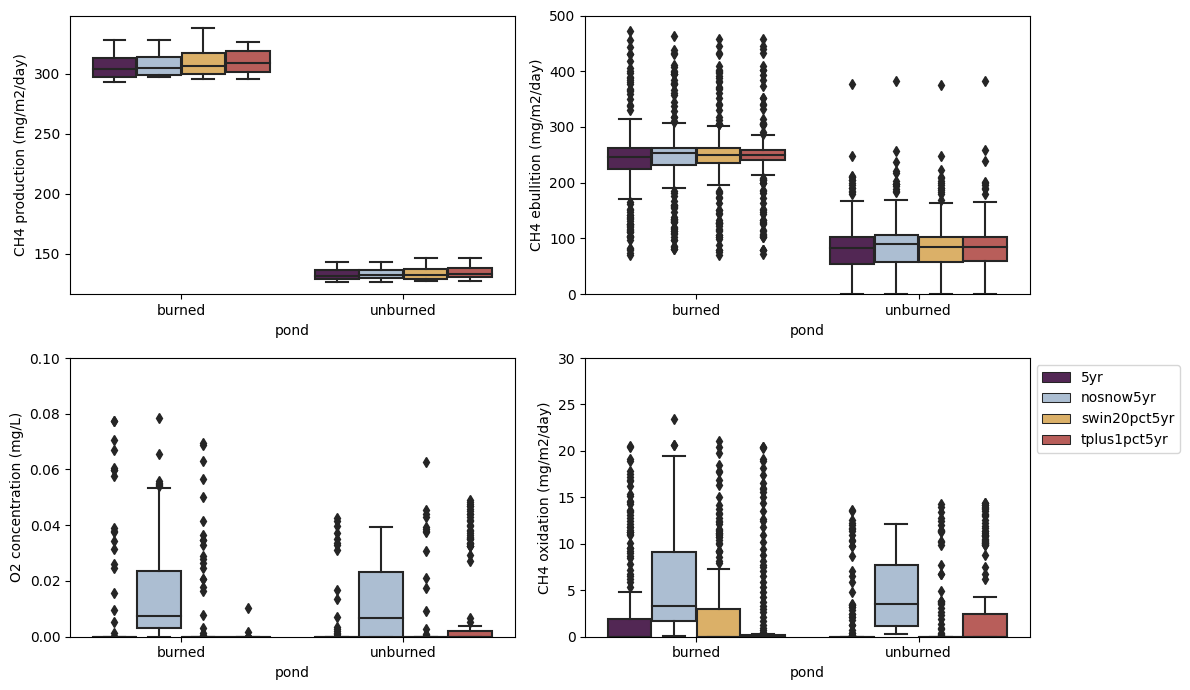

In [60]:
fig, axes=plt.subplots(2,2, figsize=(12,7))

sns.boxplot(data=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_prod_young_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[0,0], palette=pal)
axes[0,0].legend().remove()
axes[0,0].set_ylabel('CH4 production (mg/m2/day)')
#axes[0,2].set_ylim(0,2)

sns.boxplot(data=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_ebul_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[0,1], palette=pal)
axes[0,1].legend().remove()
#axes[0,0].legend(title='', loc='lower left')
axes[0,1].set_ylabel('CH4 ebullition (mg/m2/day)')
axes[0,1].set_ylim(0,500)

sns.boxplot(data=ice_on_box_data.loc[ice_on_box_data['variable'] == 'o2_water'], 
            x='pond', y='value', hue='run', ax=axes[1,0], palette=pal)
#axes[0,0].legend(title='', loc='lower left')
axes[1,0].legend().remove()
axes[1,0].set_ylabel('O2 concentration (mg/L)')
axes[1,0].set_ylim(0,1e-1)

sns.boxplot(data=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_oxid_mg/(m**2*day)'], 
            x='pond', y=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_oxid_mg/(m**2*day)']['value']*-1, hue='run', ax=axes[1,1], palette=pal)
#axes[1,1].legend().remove()
axes[1,1].legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
axes[1,1].set_ylabel('CH4 oxidation (mg/m2/day)')
axes[1,1].set_ylim(0,30)
#axes[1,1].set_yscale('log')

fig.tight_layout()
plt.savefig('met_exp_ch4_results_winter.jpg', dpi=300)

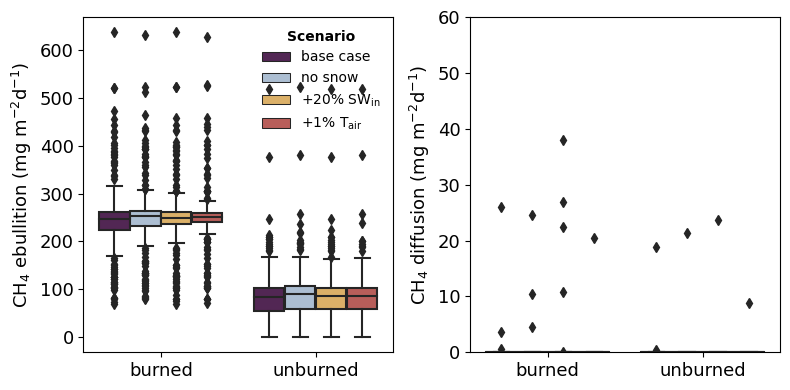

In [61]:
pal = sns.color_palette(['#591f5c', '#A6BED8', '#EEB555', '#C7504B'])
fig, axes=plt.subplots(1,2, figsize=(8,4))
sns.boxplot(data=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_ebul_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[0], palette=pal)
axes[0].legend().remove()
#axes[0,0].legend(title='', loc='lower left')
axes[0].set_ylabel('CH4 ebullition (mg/m2/day)')
axes[0].set_xlabel('')
axes[0].tick_params(axis='both', which='major', labelsize=13)
legend=axes[0].legend(title='Scenario', frameon=False, title_fontproperties={'weight':'bold'}, loc='upper right')
new_labels = ['base case', 'no snow', '+20% $\mathregular{SW_{in}}$', '+1% $\mathregular{T_{air}}$']
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
axes[0].set_ylabel(u'$\mathregular{CH_4}$ ebullition (mg $\mathregular{m^{-2}} \mathregular{d^{-1}}$)', fontsize=13)

sns.boxplot(data=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_turb_flux_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[1], palette=pal)
axes[1].legend().remove()
axes[1].set_ylabel(u'$\mathregular{CH_4}$ diffusion (mg $\mathregular{m^{-2}} \mathregular{d^{-1}}$)', fontsize=13)
axes[1].set_ylim(0, 60)
axes[1].set_xlabel('')
axes[1].tick_params(axis='both', which='major', labelsize=13)


fig.tight_layout()
plt.savefig('met_exp_ch4_results_winter.jpg', dpi=300)

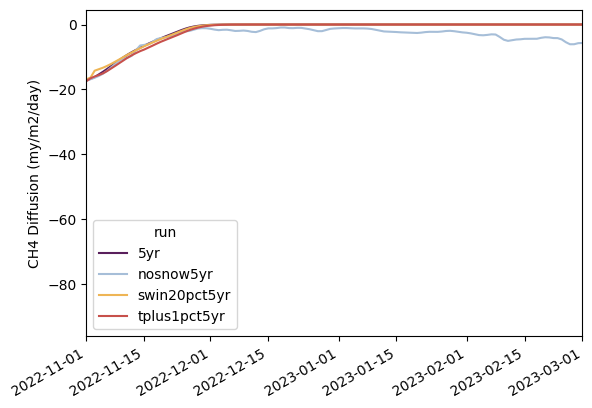

In [62]:
#pulse timing for ice breakup flux, burned
fig, ax=plt.subplots()
sns.lineplot(data= df_methanes.loc[(df_methanes['methane_ebul_mg/(m**2*day)']!=-999)& 
                                   (df_methanes['pond']=='burned')], 
                 x='Date', y='methane_oxid_mg/(m**2*day)', hue='run', palette=pal)
#plt.ylim(0,500)
plt.xlim(pd.to_datetime('2022-11-01'),pd.to_datetime('2023-03-01'))
plt.ylabel('CH4 Diffusion (my/m2/day)')
plt.xlabel('')

fig.autofmt_xdate()
#plt.savefig('CH4_diffusion_burned.jpg', dpi=300)

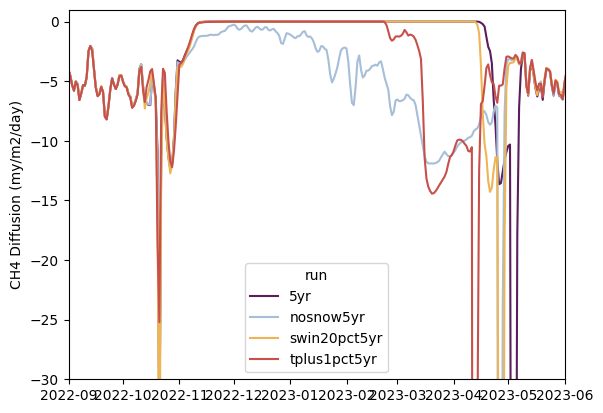

In [63]:
#pulse timing for ice breakup flux, unburned
sns.lineplot(data= df_methanes.loc[(df_methanes['methane_oxid_mg/(m**2*day)']!=-999)& 
                                   (df_methanes['pond']=='unburned')], 
                 x='Date', y='methane_oxid_mg/(m**2*day)', hue='run', palette=pal)
plt.ylim(-30,1)
plt.xlim(pd.to_datetime('2022-09-01'),pd.to_datetime('2023-06-01'))
plt.ylabel('CH4 Diffusion (my/m2/day)')
plt.xlabel('')

plt.savefig('CH4_diffusion_unburned.jpg', dpi=300)

In [64]:
df_methanes.columns

Index(['Date', 'year', 'month', 'day', 'hour', 'talik depth, m',
       'lake surface methane concentration, mol/m**3',
       'lake bottom methane concentration, mol/m**3',
       'methane_prod_young_mol/(m**2*s)', 'methane_prod_old_mol/(m**2*s)',
       'methane_diffuse_bot_mol/(m**2*s)', 'methane_ebul_mol/(m**2*s)',
       'methane_ebul_mg/(m**2*day)', 'methane_turb_flux_mol/(m**2*s)',
       'methane_turb_flux_mg/(m**2*day)', 'methane_oxid_mg/(m**2*day)',
       'methane_plant_med_flux_mg/(m**2*day)', 'co2_turb_flux_mol/(m**2*s)',
       'co2_ebul_mol/(m**2*s)', 'ox_turb_flux_mol/(m**2*s)',
       'ox_ebul_mol/(m**2*s)', 'methane_ebul_sc1', 'methane_ebul_sc2',
       'methane_ebul_sc3', 'methane_ebul_sc4', 'methane_ebul_sc5', 'run_name',
       'pond', 'run', 'ice layer thickness,   m', 'snow layer thickness,  m',
       'month_dt', 'co2_turb_flux_mg/(m**2*day)', 'co2_ebul_mg/(m**2*day)',
       'ox_turb_flux_mg/(m**2*day)', 'ox_ebul_mg/(m**2*day)', 'tot_ch4_flux',
       'tot_co2_